In [10]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# <center>Network Analysis of Financial Markets<center>
## <center>(Karthick Venkatesan)<center>

# 1. Abstract 
In this project we have analysed the dynamics of the Financial Markets through Network Analysis.We have built networks of the equities that are part of the  S and P 500 index over a range Time Periods between 2007 and 2017 based on Winner Take All and the Minimum Spanning Tree method .Both these methods utilise the correlation coefficient computed between the attributes of these stocks such as Price,Volume,Returns etc . Community detection techniques were then applied to the constructed networks. The resulting communities were compared for consistency with the identified market sections using Standard Industrial Classification code.We also studied the evolution of the network and the  communities over the study period and found interesting behaviors. We have compared our results from both the methods for each of our analysis.We created a GEXF file for this dynamic network and visuvalised the same  in Gephi a open source network visuvalisation software.The visualization results offer a very intuitive
way to look at the overall correlation structure of different the equities in the S and P 500 and evolution of these networks over a period of time .

# 2. Introduction

Network analysis of Equities is a extensively researched topic and in section 3 we have detailed current literature which was utilised as part of this project.In all the current studies the focus has been on studying the properties of the market in a stationary view  for a fixed time period.By leveraging the techniques noted in these current literature we have as part of this study built multiple networks of the stocks in the S and P 500 index for mutiple non overlapping windows of Time Period (T) between 2007 and 2017 and studied how the network evolves and how the communities in the network behave with the changing dynamics of the market.

Below are key Objectives of the project.For each of these items we have compared the results we got for for the networks built based on both these methods. 

    1. Build network for the stocks in  S and P 500 index based on the correlations between Prices/Volume for Multiple Time Periods using Winner Take All method and Minimum Spanning Tree Method
    2. Analyse the topology of the networks in multiple time periods.Does the network of stocks exhibit scale free properties at each of the time period?
    3. Detect communities in these networks and find out if the stocks actually trade in groups based on the SIC(Standard Industry Classification) Code.
    4. Studied the evolution of these communities 
    5. Find important stocks and sectors they belong to based on the Network Properties at Different time periods.
    6. Visuvalize the network and also the dynamic evolution of network by building dynamic graphs using Gephi

# 3. Literature Review

Current Studies about network analysis for stock market can be classified
into below categories : 

   (1) Applying network analysis techniques for different markets and analyze the topological characteristics of each market 
             [Statistical Analysis of Financial Markets][1],
             [Hierarchical structure in financial markets][2]
       
   (2) Propose different correlation metric analysis among various stock markets to suggest different definitions of edges between stocks and study the impact on the network using different edge definitions
             [Network analysis of a financial market based on genuine correlation and threshold method][3],
             [Network of Equities in Financial Markets][4],
             [A network perspective of the stock market][5]

[1]:https://www.researchgate.net/publication/222564938_Statistical_analysis_of_financial_networks
[2]:https://www.researchgate.net/publication/253665724_Hierarchical_structure_in_financial_market
[3]:https://www.researchgate.net/publication/228454212_Network_analysis_of_a_financial_market_based_on_genuine_correlation_and_threshold_method
[4]:https://arxiv.org/pdf/cond-mat/0401300.pdf
[5]:https://www.researchgate.net/publication/222825530_A_network_perspective_of_the_stock_market
[6]:https://www.researchgate.net/publication/5499066_Detrended_Cross-Correlation_Analysis_A_New_Method_for_Analyzing_Two_Nonstationary_Time_Series
[7]:https://www.researchgate.net/publication/44884990_Time-lag_cross-correlations_in_collective_phenomena

## 3.1. Edge Definition

Approach to construct the edges of stock market network is
not unique. In the current literature, multiple measures were
investigated to construct the edges between nodes namely [Zero-lag correlation][2],[Detrended covariance][6],[Time-lag correlations of prices changes over a certain period of time][7] 



## 3.2. Network Properties
Studies have covered both emerging and mature markets. Authors
claim that understanding the topological properties can
help to understand correlation patterns among stocks, thus providing
guidance for risk management. Topological properties
often of interest include degree distribution, clustering and component
structure. In this subcategory study, usually only one
correlation measure is proposed to establish the connections
between nodes. In the introduction session of [Statistical Analysis of Financial Markets][1], the author
covered a wide range of previous studies in this category

# 4. Build Network
## 4.1 Data Collection

We collected the prices for the stocks that trade in both NASDAQ and the NYSE stock exchange from [Eod Data][8] . The data consisted of Opening , Closing prices , Volume information for each trading day for the period of 2007 to 2017.From this data we filtered and selected only the prices that are a part of S and P 500 . We chose the [S and P 500][9] since the index had a well balanced portfolio of stocks from different industry segments .

[8]:http://eoddata.com/
[9]:https://en.wikipedia.org/wiki/S%26P_500_Index

In [5]:
## Read S and P 500 list
import pandas as pd
import numpy as np
dfsp500 = pd.read_csv('data/SANDP500.csv')
companies=dfsp500['Symbol'].tolist()
companies=np.random.choice(companies, size=500, replace=False)

In [6]:
import glob
import os
path = r'data/NASDAQ'                     
all_files = glob.glob(os.path.join(path, "*.txt"))     
df_from_each_file = (pd.read_csv(f) for f in all_files)
concatenated_df_NAS   = pd.concat(df_from_each_file, ignore_index=True)
concatenated_df_NAS=concatenated_df_NAS[concatenated_df_NAS['<ticker>'].isin(companies)]

path = r'data/NYSE'                     
all_files = glob.glob(os.path.join(path, "*.txt"))     
df_from_each_file = (pd.read_csv(f) for f in all_files)
concatenated_df_NYS   = pd.concat(df_from_each_file, ignore_index=True)
concatenated_df_NYS=concatenated_df_NYS[concatenated_df_NYS['<ticker>'].isin(companies)]

concatenated_df = pd.concat([concatenated_df_NAS,concatenated_df_NYS])

In [7]:
col_p = 'close'
concatenated_df.columns = ['ticker','date','open','high','low','close','vol']
concatenated_df=concatenated_df[concatenated_df['ticker'].isin(companies)]
concatenated_df=concatenated_df.merge(dfsp500,left_on='ticker',right_on='Symbol')
concatenated_df['ticker'] = concatenated_df['ticker']
df_price = concatenated_df[['ticker','date',col_p]]
df_price=df_price.drop_duplicates( keep='last')
df_price['date'] = pd.to_datetime(df_price['date'], format='%Y%m%d', errors='ignore')
df_price.set_index(['date','ticker'],inplace=True)
df_price=df_price.unstack()[col_p]
df_price.reset_index(inplace=True)
df_price.fillna(method='bfill',inplace=True)
df_price.fillna(method='ffill',inplace=True)

## 4.2 Detrend data - Compute log returns

Of the methods in current literature number we choose [Time-lag correlations of prices changes over a certain period of time][7] .One of the keys challenges in computing the correlation on stock prices is that the values are moving time series and have inherent trends which can lead to spurious correlations if the data is not properly normalised.

If we think about a time series of prices, you could write it out as 

    [P0,P1,P2,...,PN], or [P0,P0+R1,P0+R1+R2,...,P0+R1+...+RN], where Ri = Pi-P(i-1). 

Written this way we can see that the first return R1, contributes to every entry in the series, whereas the last only contributes to one. This gives the early values in the correlation of prices more weight than they should have.

So for computing the correlation we take the difference between the prices for each day giving us the returns for each .We computed the log returns between two days since it has a key benefit of being additive over multiple time periods .

Though log returns can be computed over multiple time periods of 7 , 30 , 60 , 100 days for the sake of simplicity we kept the return window to 1 day.

[7]:https://www.researchgate.net/publication/44884990_Time-lag_cross-correlations_in_collective_phenomena

In [8]:
import scipy.signal
t = 1
for key in df_price.columns:
    if key not in companies:
        continue
    try:
        df_price[key] = np.log(df_price[key]) - np.log(df_price[key].shift(t))
    except:
        print (key)
df_price.set_index('date',inplace=True)

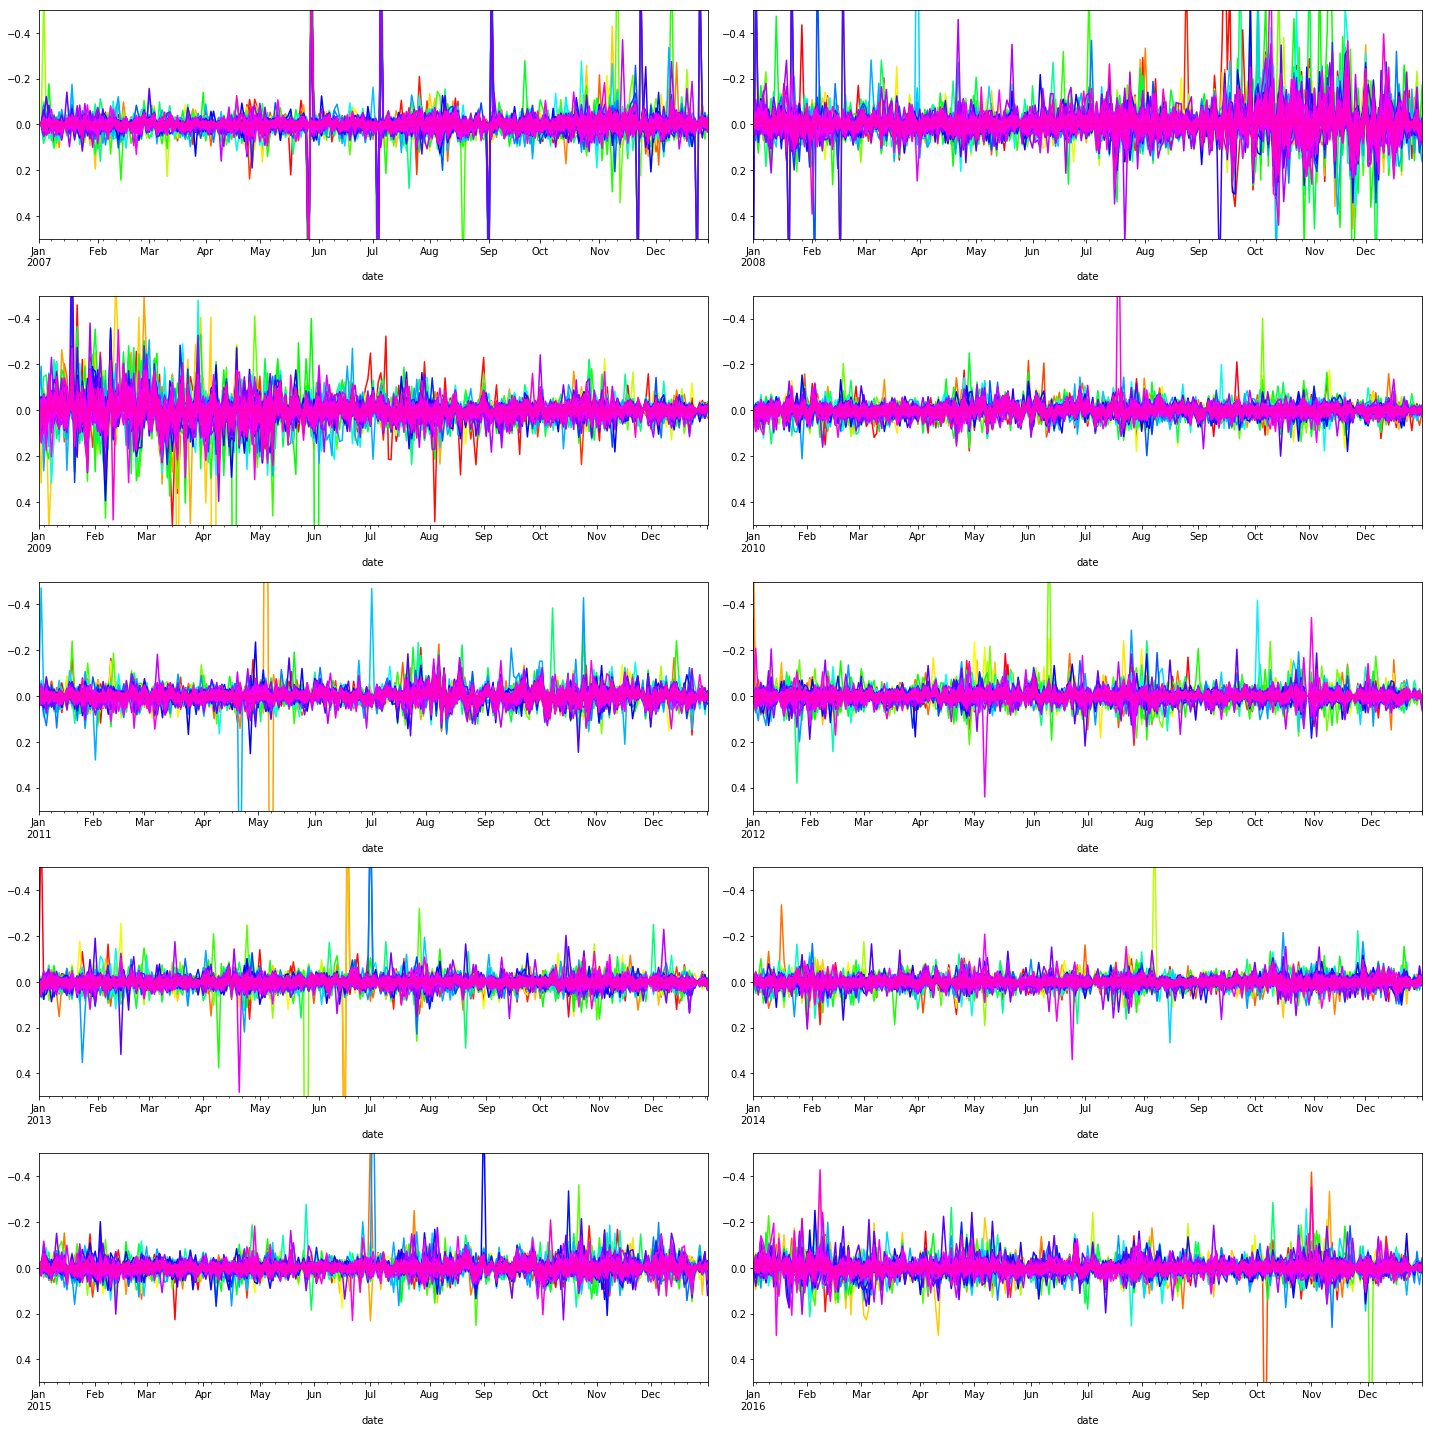

In [9]:
## A quick visualization: detrended data
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn
NUM_COLORS = len(companies)
cm = plt.get_cmap('gist_rainbow')
colors = [cm(i/NUM_COLORS) for i in range(NUM_COLORS)]
rn.seed = len(companies)  # for choosing random colors
fig, ax = plt.subplots(nrows=5,ncols=2,figsize=(20, 20))
y=2007
for row in ax:
    for col in row:
        yfs = str(y) + '0101'
        yfe = str(y) + '1231'
        n = 0
        col.set_ylim([0.5, -0.5])
        for i in df_price.columns:
            df_price.loc[yfs:yfe][i].plot(ax=col,color=colors[n])
            n = n + 1
        y = y + 1
plt.tight_layout()
plt.show()

## 4.3 Compute Correlation matrix for multiple windows

Next we computed the pearson correlation between the log returns.The data is divided into  windows of width (T)  in order to uncover dynamic characteristics of the networks. The window width  corresponds to the number of daily returns included in the computation of the correlation between Stocks. The method of time windows division to construct asset graphs can be found in the literature [Asset trees and asset graphs in financial markets][10]

To determine the ideal length of the window we computed the mean correlation for window values of 21,42,63,84 and 105 and plotted the variations in the correlation.As seen in the plot the window of 63 captures the fluctuations of the market well.Values less than this are too noisy and higher than this we lose the sensitivity in the changes in the market .Also from a market perspective 63 days ideally falls into the Quarterly reporting cycle of these companies so we felt it would be appropriate choice

The correlation matrix is then computed based on this window length of 63 by dividing the period between 2007 and 2017 into multiple windows.

[10]:https://arxiv.org/abs/cond-mat/0303579

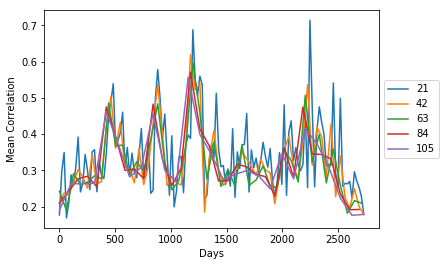

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
corr_dict = {}
T = 1
for w in range(21,126,21):
    x = []
    y = []
    W = w
    for i in range(t,len(df_price),W):
            dkey = i
            corr_dict[dkey]=df_price.iloc[i:(i+W)].corr(method='pearson')
            corr_dict[dkey].fillna(0,inplace=True)
            x.append(dkey)
            y.append(np.mean([abs(j) for j in corr_dict[dkey].values.flatten().tolist()]))
    plt.plot(x,y)
    plt.xlabel('Days')
    plt.ylabel('Mean Correlation')
    plt.legend(list(range(21,126,21)), loc='center left', bbox_to_anchor=(1, 0.5),ncol=1)
plt.show()
W = 63
corr_dict = {}
for i in range(t,len(df_price),W):
      dkey = i
      corr_dict[dkey]=df_price.iloc[i:(i+W)].corr(method='pearson')
      corr_dict[dkey].fillna(0,inplace=True)

# 4.4 Build network - (Winner take all method)
Literature [A network perspective of the stock market][5] details the winner take all method where we build a network based on the correlation matrix if the value of the Correlation index is greater than a threshold.

What is the ideal value of threshold ?.Since one the key objectives of the study is to find if the stocks behave in groups we wanted to select a threshold which maximises the modularity .However we were also consious not overfit the data in which case we might loose some of the underlying dynamics at work in the market.

In the next step we built the network based on different thresholds ranging from 0.6 to 0.99 for  the windows identified .We then picked the value of the threshold from the values where the modularity is maximum.On analysis of this result we noted that most networks tended to have a high modularity for threshold value between 0.75 and 0.85 .There were certains windows where the threshold for the best modularity was seen to be greater than 0.9 however at this threshold the number edges was very less so in such cases we set the threshold to 0.8 and built the network.We treated both positive and negative correlations the same and looked at the absolute value.

[5]:https://www.researchgate.net/publication/222825530_A_network_perspective_of_the_stock_market

In [8]:
import networkx as nx
import community
def get_modularity(y,threshold):
    df_price_corr = corr_dict[y]
    elist = []
    outdict=df_price_corr.to_dict()
    for i in outdict.keys():
        for j in outdict[i].keys():    
            if abs(outdict[i][j]) > threshold :
                if i == j :
                    continue
                if i < j:
                    elist.append([i,j,dict(weight=abs(outdict[i][j]),start=y,end=y+W)])
                    #elist.append([i,j,dict(start=y,end=y+1)])
                else:
                    None
    #print (len(elist))
    G=nx.Graph()
    G.add_edges_from(elist)
    #print (nx.info(G))
    partition = community.best_partition(G)
    try:
        m = community.modularity(partition, G)
    except:
        m = 0 
    return m
# This will be our list of fractions to run the simulation over
fractions = np.linspace(0.6, 0.99, 20)
M_list = {}
for y in corr_dict.keys():
    M_list[y] = [ get_modularity(y, frac)  for frac in fractions ]

The below is the plot between the threshold value and the computed markdown in the various windows

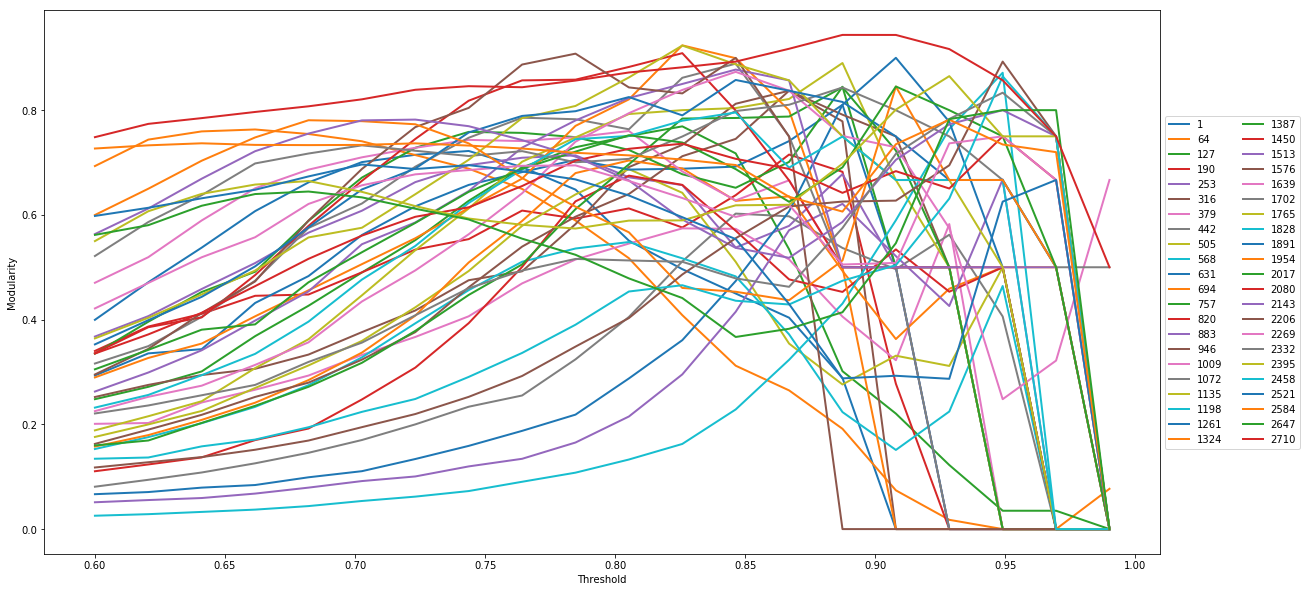

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,10))
for y in corr_dict.keys():
    plt.plot(fractions, M_list[y], lw=2)
plt.legend(list(M_list.keys()), loc='center left', bbox_to_anchor=(1, 0.5),ncol=2)
plt.xlabel('Threshold')
plt.ylabel('Modularity')
plt.show()

In [11]:
# Pick value of threshold for each Window (T)
T_val = {}
for y in M_list.keys():
    val, idx = max((val, idx) for (idx, val) in enumerate(M_list[y]))
    if fractions[idx] > 0.8:
        T_val[y] = 0.8
    else:
        T_val[y] = fractions[idx]
    #print (str(y) + ":" + str(T_val[y]))

In [12]:
# Create Edge List
elist_dict={}
for y in corr_dict.keys():
    df_price_corr = corr_dict[y]
    threshold = T_val[y]
    elist = []
    outdict=df_price_corr.to_dict()
    for i in outdict.keys():
        for j in outdict[i].keys():
            if abs(outdict[i][j]) > threshold :
                if i == j :
                    continue
                if i < j:
                    elist.append([i,j,dict(weight=1,start=y,end=y+W-1)])
                else:
                    None
    elist_dict[y] = elist

In [13]:
# Constructing the graph different windows
import networkx as nx
import community
G_dict = {}
for y in elist_dict.keys():
    G=nx.Graph()
    elist = elist_dict[y]
    G.add_edges_from(elist)
    values = dfsp500.set_index('Symbol').to_dict(orient='dict')['Sector']
    for node, value in values.items():
        try:
            G.node[node]['Sector'] = value
        except:
            #name = (value[0:3] + '-' + node)
            #G.add_node(name,Sector=value)
            None
    partition = community.best_partition(G)
    
    deg_cent=dict((k,float(v)) for k,v in nx.degree_centrality(G).items())
    degree = dict((k,float(v)) for k,v in nx.degree(G).items())
    #katz_cent=nx.katz_centrality(G)
    #eigen_cent= dict((k,float(v)) for k,v in nx.eigenvector_centrality(G).items()) 
    close_cent= dict((k,float(v)) for k,v in nx.closeness_centrality(G).items())  
    betw_cent= dict((k,float(v)) for k,v in nx.betweenness_centrality(G).items()) 
    nx.set_node_attributes(G, "community", partition)  
    nx.set_node_attributes(G, "degreecent", deg_cent)
    nx.set_node_attributes(G, "degree", degree)
    #nx.set_node_attributes(G, "katz", katz_cent)
    #nx.set_node_attributes(G, "eigenvector", eigen_cent)
    nx.set_node_attributes(G, "closeness", close_cent)
    nx.set_node_attributes(G, "betweenness", betw_cent)
    nx.set_node_attributes(G, 'start',y)
    nx.set_node_attributes(G, 'end',y+W-1)
    #G.remove_nodes_from(nx.isolates(G)) 
    #T = nx.minimum_spanning_tree(G)
    T = G
    G_dict[y] = T

In [14]:
# Collect the node level attributes for the nodes for all the windows
df_list = []
for k in G_dict.keys():
    G = G_dict[k]
    a = G.node
    df_list.append(pd.DataFrame(a).T.reset_index())
attrib_df = pd.concat(df_list)
attrib_df.fillna(0,inplace=True)
attrib_df1=attrib_df.merge(dfsp500,left_on='index',right_on='Symbol')
attrib_df = attrib_df1[['index','Sector_x','betweenness','closeness','community','degree','degreecent','start','Name']]
attrib_df.columns=['ticker','Sector','Betweeness','Closeness','Community','Degree','DegreeCent','start','Name']

In [15]:
# Collect the graph level  attributes for all the windows
from scipy.stats import linregress
G_val_dict = {}
for Y in G_dict.keys():
    G_val = {}
    G= G_dict[Y]
    G_val['nodes'] =  int(nx.number_of_nodes(G))
    G_val['edges'] =  int(nx.number_of_edges(G))
    #G_val['AvgDegree'] =  nx.average_degree(G)
    G_val['AvgClustering'] = nx.average_clustering(G)
    try:
        G_val['AvgShortestPathLength'] = nx.average_shortest_path_length(G)
    except:
        G_val['AvgShortestPathLength'] = 99999
    try:
        G_val['Diameter'] = nx.diameter(G)
    except:
        G_val['Diameter'] = 99999
    degs = {}
    for n in G.nodes() :
        deg = G.degree(n)
        if deg not in degs.keys() :
            degs[deg] = 0
        degs[deg] += 1
    items = sorted(degs.items())
    x= [k for (k , v ) in items ]
    y= [ v for (k ,v ) in items ]
    xlog= np.array([np.log(k) for (k , v ) in items ])
    ylog= np.array([np.log(v) for (k ,v ) in items ])
    slope,intercept,rvalue,pvalue,stderr=linregress(xlog,ylog)
    G_val['Slope'] = slope
    G_val['No of Communities'] = attrib_df.groupby(by=['start'])['Community'].nunique().ix[Y]
    G_val_dict[Y] = G_val
Gvaldf=pd.DataFrame(G_val_dict).T

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


The below table lists the network  properties for the networks created using the Winner Take All Method Method over multiple Time Periods.

In [16]:
pd.options.display.max_rows = 999
Gvaldf

AvgClustering  AvgShortestPathLength  Diameter  No of Communities  \
1          0.437301           99999.000000   99999.0               17.0   
64         0.583921           99999.000000   99999.0               19.0   
127        0.538656           99999.000000   99999.0               16.0   
190        0.464502           99999.000000   99999.0               17.0   
253        0.343108           99999.000000   99999.0               21.0   
316        0.337280           99999.000000   99999.0               20.0   
379        0.472535           99999.000000   99999.0               22.0   
442        0.497699           99999.000000   99999.0               11.0   
505        0.439454           99999.000000   99999.0               18.0   
568        0.429914           99999.000000   99999.0               20.0   
631        0.397613           99999.000000   99999.0               18.0   
694        0.489646           99999.000000   99999.0               20.0   
757        0.351498           99999.000000   99999.0               14.0   
820        0.378896           99999.000000   99999.0               22.0   
883        0.618682           99999.000000   99999.0               14.0   
946        0.340429           99999.000000   99999.0               18.0   
1009       0.111712           99999.000000   99999.0               11.0   
1072       0.128993           99999.000000   99999.0               22.0   
1135       0.371843           99999.000000   99999.0               22.0   
1198       0.732433               1.884846       5.0                4.0   
1261       0.586980           99999.000000   99999.0               13.0   
1324       0.151453           99999.000000   99999.0               17.0   
1387       0.374351           99999.000000   99999.0               20.0   
1450       0.123333           99999.000000   99999.0               15.0   
1513       0.235170           99999.000000   99999.0               22.0   
1576       0.050292           99999.000000   99999.0               24.0   
1639       0.369880           99999.000000   99999.0               26.0   
1702       0.422181           99999.000000   99999.0               16.0   
1765       0.203037           99999.000000   99999.0               20.0   
1828       0.260765           99999.000000   99999.0               20.0   
1891       0.304440           99999.000000   99999.0               22.0   
1954       0.448140           99999.000000   99999.0               21.0   
2017       0.344473           99999.000000   99999.0               36.0   
2080       0.515361           99999.000000   99999.0               32.0   
2143       0.323645           99999.000000   99999.0               27.0   
2206       0.537092           99999.000000   99999.0               26.0   
2269       0.443097           99999.000000   99999.0               37.0   
2332       0.301949           99999.000000   99999.0               43.0   
2395       0.469023           99999.000000   99999.0               31.0   
2458       0.454574           99999.000000   99999.0               32.0   
2521       0.446138           99999.000000   99999.0               37.0   
2584       0.470094           99999.000000   99999.0               23.0   
2647       0.439164           99999.000000   99999.0               28.0   
2710       0.352363           99999.000000   99999.0               40.0   

         Slope    edges  nodes  
1    -0.734717    462.0  139.0  
64   -0.555489    897.0  178.0  
127  -1.081694    307.0  112.0  
190  -0.917059    222.0   84.0  
253  -1.244365    379.0  149.0  
316  -1.183432    253.0  121.0  
379  -0.892980    781.0  171.0  
442  -0.829045   3798.0  344.0  
505  -1.018640    696.0  192.0  
568  -0.967200   1108.0  215.0  
631  -1.110171    303.0  120.0  
694  -1.072235    266.0  110.0  
757  -1.209373    142.0   83.0  
820  -1.131378    470.0  173.0  
883  -0.514376   6146.0  309.0  
946  -1.257725    219.0  106.0  
1009 -1.735520     33.0   37.0  
1072 -1.509773     59.0   64.0  
113

## 4.5. Build network - Minimum Spanning Tree  Method

One of the negatives of the Winner Take all method is that in certain period the threshold gave us highly noisy data .There were two many edges in the graph and results during this period are difficult to visuvalise .In this section we built the same network  based on the Minimum Spanning tree method as noted in [Network of Equities in Financial Markets][4] .

In case of the minimum spanning tree method a metric distance dij is calculated using the cross correlation matrix.

			dij = (2(1-Cij))^(0.5)
            
Where dij is the edge distance between stock i and stock j. 

To find the ideal window size for constructing the network we computed the mean distance metric for mutiple windows ranging from 21 to 105 .The plot of the results is below.The Results largely indicate similar pattern to mean correlation we saw in the Winner take all method.Here to we can see that the window size of 63 resonable captures the fluctuations in the market.So we used the window width of 63 to compute the correlation and the corresponding distance metric and built the networks using the Minimum Spanning Tree Method.

[4]:https://arxiv.org/pdf/cond-mat/0401300.pdf

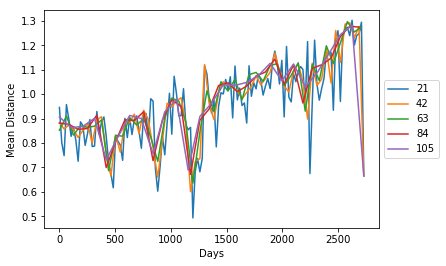

In [17]:
import math
import matplotlib.pyplot as plt
%matplotlib inline
def calc_d(x):
    x = round(x,3)
    d = math.sqrt(2 * (1 - x))
    return d
corr_dict = {}
corr_dist_dict = {}
T = 1
W = 63
x = []
y = []
for w in range(21,126,21):
    x = []
    y = []
    W = w
    for i in range(t,len(df_price),W):
            dkey = i
            corr_dict[dkey]=df_price.iloc[i:(i+W)].corr(method='pearson')
            corr_dict[dkey].fillna(1,inplace=True)
            corr_dist_dict[dkey] = corr_dict[dkey].applymap(calc_d)
            x.append(dkey)
            y.append(np.mean([abs(j) for j in corr_dist_dict[dkey].values.flatten().tolist()]))
    plt.plot(x,y)
    plt.xlabel('Days')
    plt.ylabel('Mean Distance')
    plt.legend(list(range(21,126,21)), loc='center left', bbox_to_anchor=(1, 0.5),ncol=1)
W = 63
corr_dict = {}
corr_dist_dict = {}
for i in range(t,len(df_price),W):
      dkey = i
      corr_dict[dkey]=df_price.iloc[i:(i+W)].corr(method='pearson')
      corr_dict[dkey].fillna(1,inplace=True)
      corr_dist_dict[dkey] = corr_dict[dkey].applymap(calc_d)

In [18]:
#MST Start 
elistmst_dict={}
for y in corr_dist_dict.keys():
    df_price_corr = corr_dist_dict[y]
    elistmst = []
    outdict=df_price_corr.to_dict()
    for i in outdict.keys():
        for j in outdict[i].keys():
            if (abs(outdict[i][j]) > 0 and (i>j)):
                elistmst.append([i,j,dict(weight=abs(outdict[i][j]),start=y,end=y+W-1)])
    elistmst_dict[y] = elistmst

In [19]:
import networkx as nx
import community
GMST_dict = {}
for y in elistmst_dict.keys():
    G=nx.Graph()
    elist = elistmst_dict[y]
    G.add_edges_from(elist)
    T = nx.minimum_spanning_tree(G)
    G = T
    values = dfsp500.set_index('Symbol').to_dict(orient='dict')['Sector']
    for node, value in values.items():
        try:
            G.node[node]['Sector'] = value
        except:
            #name = (value[0:3] + '-' + node)
            #G.add_node(name,Sector=value)
            None
    partition = community.best_partition(G)
    
    deg_cent=dict((k,float(v)) for k,v in nx.degree_centrality(G).items())
    degree = dict((k,float(v)) for k,v in nx.degree(G).items())
    #katz_cent=nx.katz_centrality(G)
    #eigen_cent= dict((k,float(v)) for k,v in nx.eigenvector_centrality(G).items()) 
    close_cent= dict((k,float(v)) for k,v in nx.closeness_centrality(G).items())  
    betw_cent= dict((k,float(v)) for k,v in nx.betweenness_centrality(G).items()) 
    nx.set_node_attributes(G, "community", partition)  
    nx.set_node_attributes(G, "degreecent", deg_cent)
    nx.set_node_attributes(G, "degree", degree)
    #nx.set_node_attributes(G, "katz", katz_cent)
    #nx.set_node_attributes(G, "eigenvector", eigen_cent)
    nx.set_node_attributes(G, "closeness", close_cent)
    nx.set_node_attributes(G, "betweenness", betw_cent)
    nx.set_node_attributes(G, 'start',y)
    nx.set_node_attributes(G, 'end',y+W)
    T = G
    GMST_dict[y] = T

In [20]:
df_list = []
for k in GMST_dict.keys():
    G = GMST_dict[k]
    a = G.node
    df_list.append(pd.DataFrame(a).T.reset_index())
attribMST_df = pd.concat(df_list)
attribMST_df.fillna(0,inplace=True)
attribMST_df1=attribMST_df.merge(dfsp500,left_on='index',right_on='Symbol')
attribMST_df = attribMST_df1[['index','Sector_x','betweenness','closeness','community','degree','degreecent','start','Name']]
attribMST_df.columns=['ticker','Sector','Betweeness','Closeness','Community','Degree','DegreeCent','start','Name']

In [21]:
from scipy.stats import linregress
G_valMST_dict = {}
for Y in GMST_dict.keys():
    G_val = {}
    G= GMST_dict[Y]
    G_val['nodes'] =  nx.number_of_nodes(G)
    G_val['edges'] =  nx.number_of_edges(G)
    #G_val['AvgDegree'] =  nx.average_degree(G)
    G_val['AvgClustering'] = nx.average_clustering(G)
    try:
        G_val['AvgShortestPathLength'] = nx.average_shortest_path_length(G)
    except:
        G_val['AvgShortestPathLength'] = 99999
    try:
        G_val['Diameter'] = nx.diameter(G)
    except:
        G_val['Diameter'] = 99999
    degs = {}
    for n in G.nodes() :
        deg = G.degree(n)
        if deg not in degs.keys() :
            degs[deg] = 0
        degs[deg] += 1
    items = sorted(degs.items())
    x= [k for (k , v ) in items ]
    y= [ v for (k ,v ) in items ]
    xlog= np.array([np.log(k) for (k , v ) in items ])
    ylog= np.array([np.log(v) for (k ,v ) in items ])
    slope,intercept,rvalue,pvalue,stderr=linregress(xlog,ylog)
    G_val['Slope'] = slope
    G_val['No of Communities'] = attribMST_df.groupby(by=['start'])['Community'].nunique().ix[Y]
    G_valMST_dict[Y] = G_val
GMST_df=pd.DataFrame(G_valMST_dict).T

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


The below table lists the network  properties for the networks created using the Minimum Spanning Tree Method over multiple Time Periods.

In [22]:
GMST_df

AvgClustering  AvgShortestPathLength  Diameter  No of Communities  \
1               0.0              10.006982      25.0               23.0   
64              0.0              11.656817      30.0               24.0   
127             0.0              11.685365      25.0               24.0   
190             0.0              12.705015      33.0               23.0   
253             0.0              13.100791      30.0               24.0   
316             0.0              12.929396      34.0               25.0   
379             0.0              11.736004      37.0               23.0   
442             0.0               9.870432      24.0               23.0   
505             0.0              11.700028      29.0               26.0   
568             0.0              11.991151      28.0               25.0   
631             0.0              12.206835      32.0               25.0   
694             0.0              11.966274      28.0               23.0   
757             0.0              10.225780      26.0               25.0   
820             0.0              10.720473      25.0               22.0   
883             0.0               9.268146      24.0               25.0   
946             0.0               7.232595      17.0               24.0   
1009            0.0              11.460324      27.0               23.0   
1072            0.0               9.898856      27.0               23.0   
1135            0.0              11.048054      26.0               24.0   
1198            0.0              10.048669      24.0               25.0   
1261            0.0               9.375795      21.0               26.0   
1324            0.0              10.258025      25.0               22.0   
1387            0.0              10.286589      26.0               26.0   
1450            0.0               9.377163      25.0               22.0   
1513            0.0              11.060595      28.0               24.0   
1576            0.0               9.406258      27.0               23.0   
1639            0.0               9.620221      21.0               23.0   
1702            0.0              10.191933      27.0               27.0   
1765            0.0               9.666815      26.0               25.0   
1828            0.0              10.022886      25.0               23.0   
1891            0.0              13.378051      41.0               27.0   
1954            0.0              12.746888      38.0               26.0   
2017            0.0              12.801533      33.0               25.0   
2080            0.0              11.445382      30.0               26.0   
2143            0.0              11.845514      36.0               25.0   
2206            0.0              11.853195      31.0               26.0   
2269            0.0              14.269999      38.0               25.0   
2332            0.0              11.389670      27.0               24.0   
2395            0.0              15.049847      33.0               25.0   
2458            0.0              12.346634      32.0               26.0   
2521            0.0              16.771448      47.0               25.0   
2584            0.0              15.656228      36.0               25.0   
2647            0.0              14.443294      41.0               25.0   
2710            0.0              14.880367      34.0               26.0   

         Slope  edges  nodes  
1    -2.302370  429.0  430.0  
64   -2.511209  431.0  432.0  
127  -2.414082  434.0  435.0  
190  -2.094925  436.0  437.0  
253  -2.414212  436.0  437.0  
316  -2.226890  440.0  441.0  
379  -2.397362  442.0  443.0  
442  -2.176792  444.0  445.0  
505  -2.423807  448.0  449.0  
568  -2.337993  448.0  449.0  
631  -2.094288  447.0  448.0  
694  -2.401395  448.0  449.0  
757  -2.400149  448.0  449.0  
820  -2.286885  450.0  451.0  
883  -2.270480  451.0  452.0  
946  -2.094576  453.0  454.0  
1009 -2.404244  455.0  456.0  
1072 -2.202451  457.0  458.0  
1135 -2.306812  458.0  459.0  
1198 -2.20

# 5. Result 

## 5.1 Degree distribution and Scale Free Properties

We plotted the degree distribution histogram and also plotted the degree distribution on a log log plotted and regression fitted a line whose slope will give as the Power law exponent.The plot show that network shows scale free properties in most of the windows .The scale free nature is more evident in the Networks generated based on the Minimum Spanning Tree Method .

### Winner Take All Method

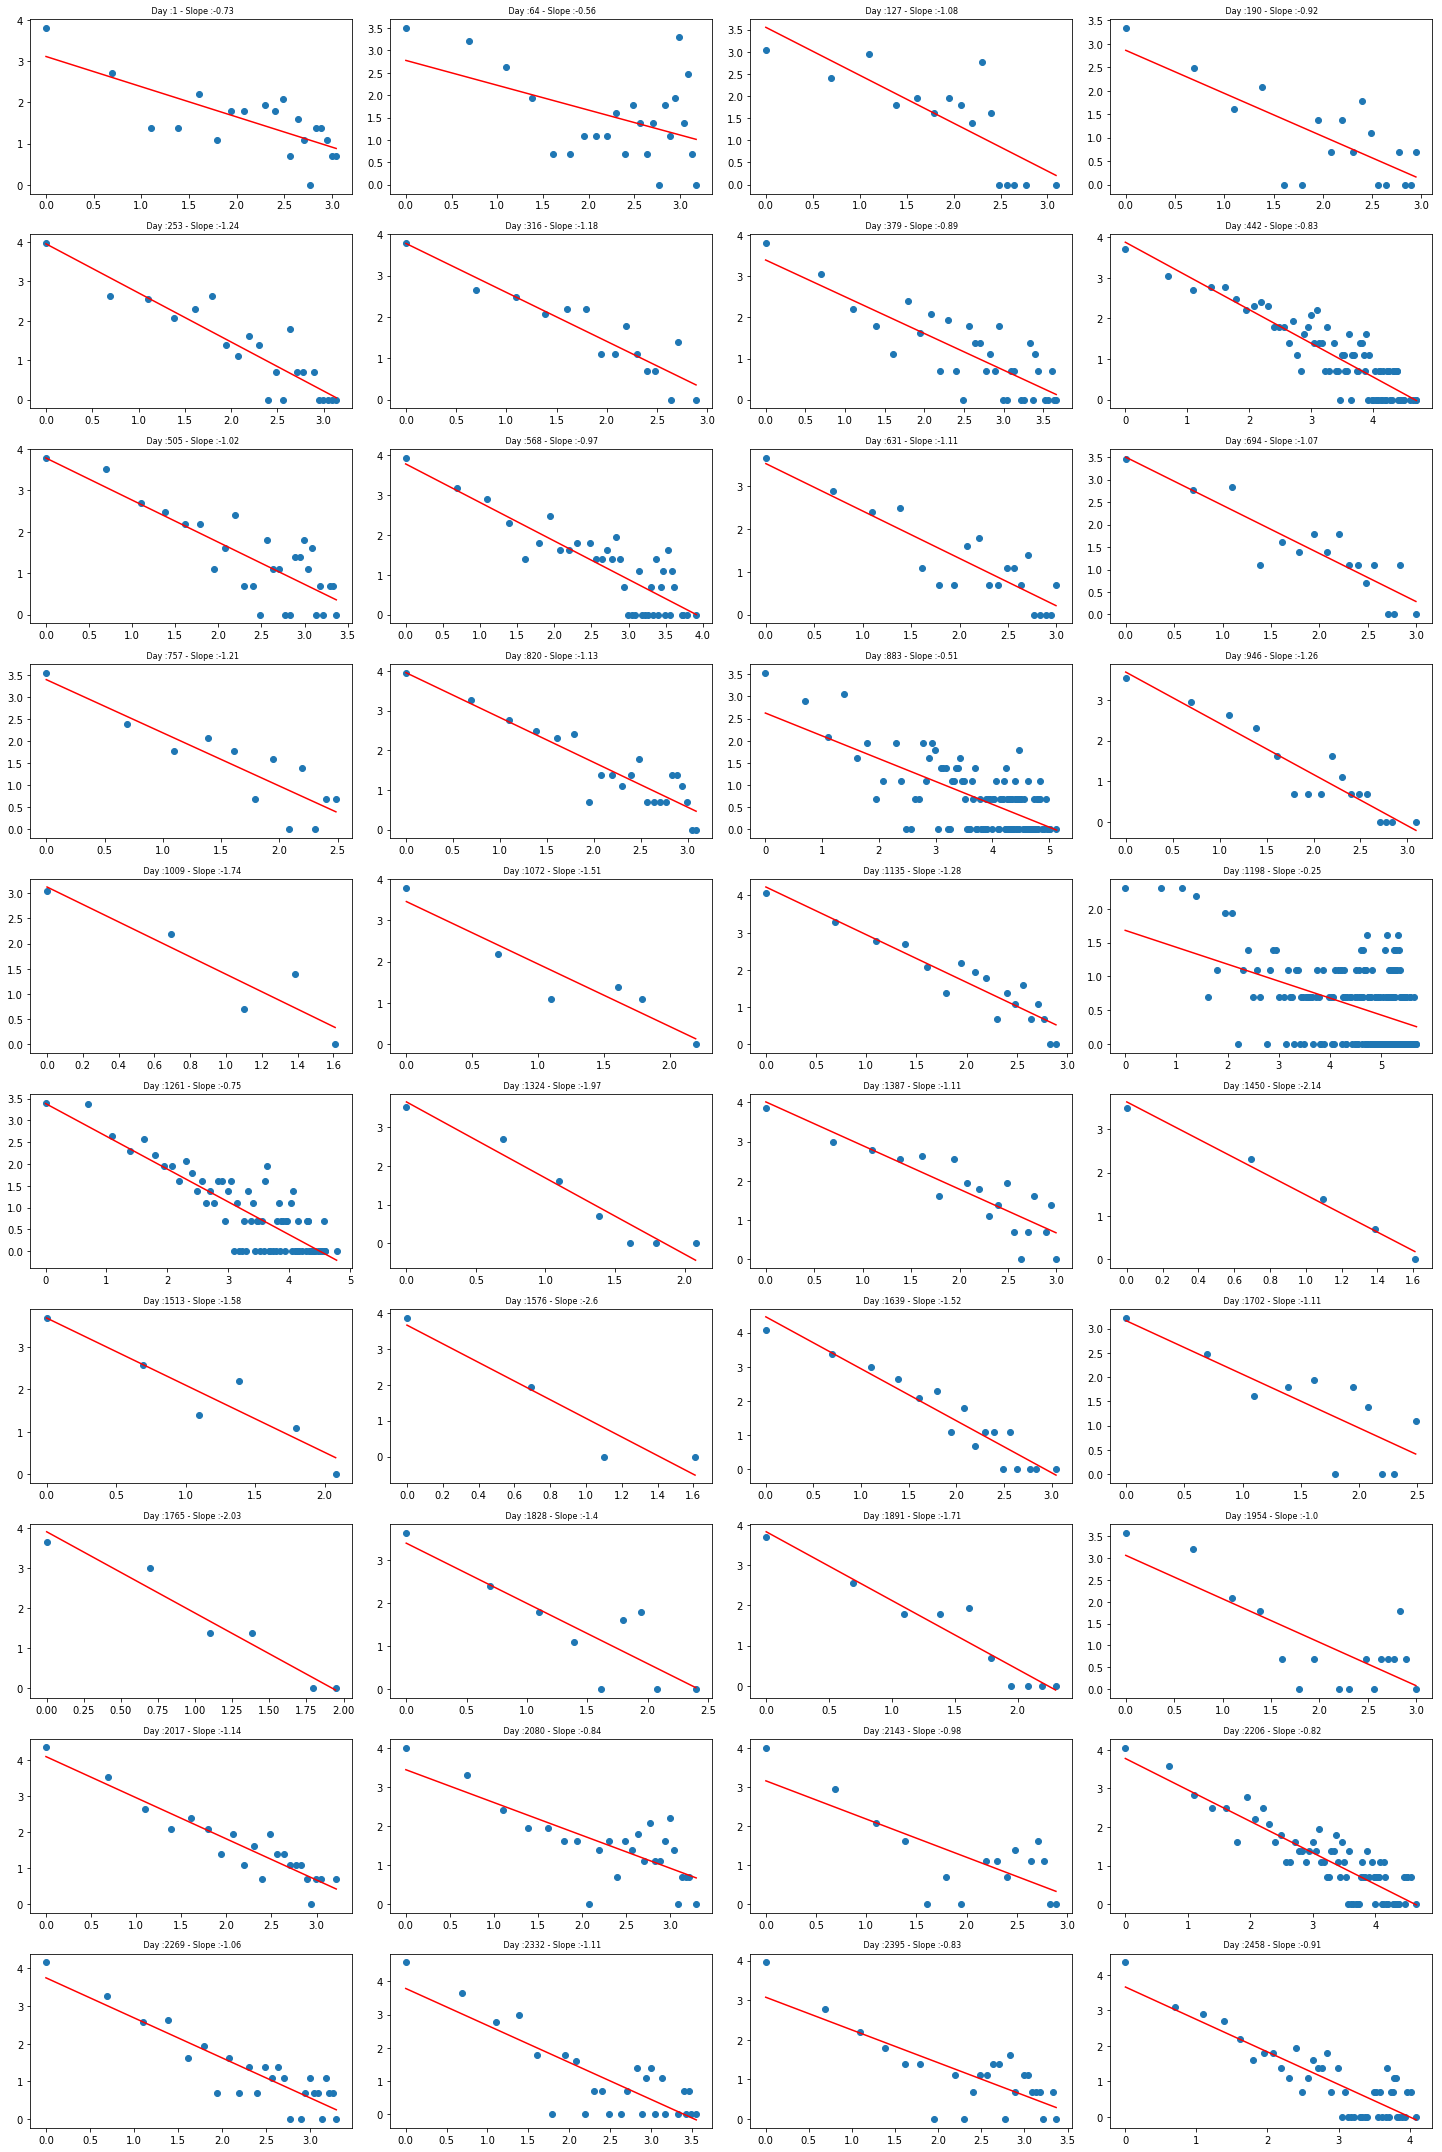

In [23]:
## Explore graph properties
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import linregress
fig, ax = plt.subplots(nrows=10,ncols=4,figsize=(20, 30))
Y = 1
for row in ax:
    for col in row:
        degs = {}
        for n in G_dict[Y].nodes() :
            deg = G_dict[Y].degree(n)
            if deg not in degs.keys() :
                degs[deg] = 0
            degs[deg] += 1
        items = sorted(degs.items())
        x= [k for (k , v ) in items ]
        y= [ v for (k ,v ) in items ]
        xlog= np.array([np.log(k) for (k , v ) in items ])
        ylog= np.array([np.log(v) for (k ,v ) in items ])
        col.scatter(xlog, ylog)
        slope,intercept,rvalue,pvalue,stderr=linregress(xlog,ylog)
        col.plot(xlog, (slope * xlog + intercept), color='red')
        #ax.set_xscale( 'log' )
        #ax.set_yscale( 'log' )
        col.set_title ( " Day :" + str(Y) + " - Slope :" + str(round(slope,2) ),fontsize=8)
        Y = Y + W
plt.tight_layout()
plt.show()

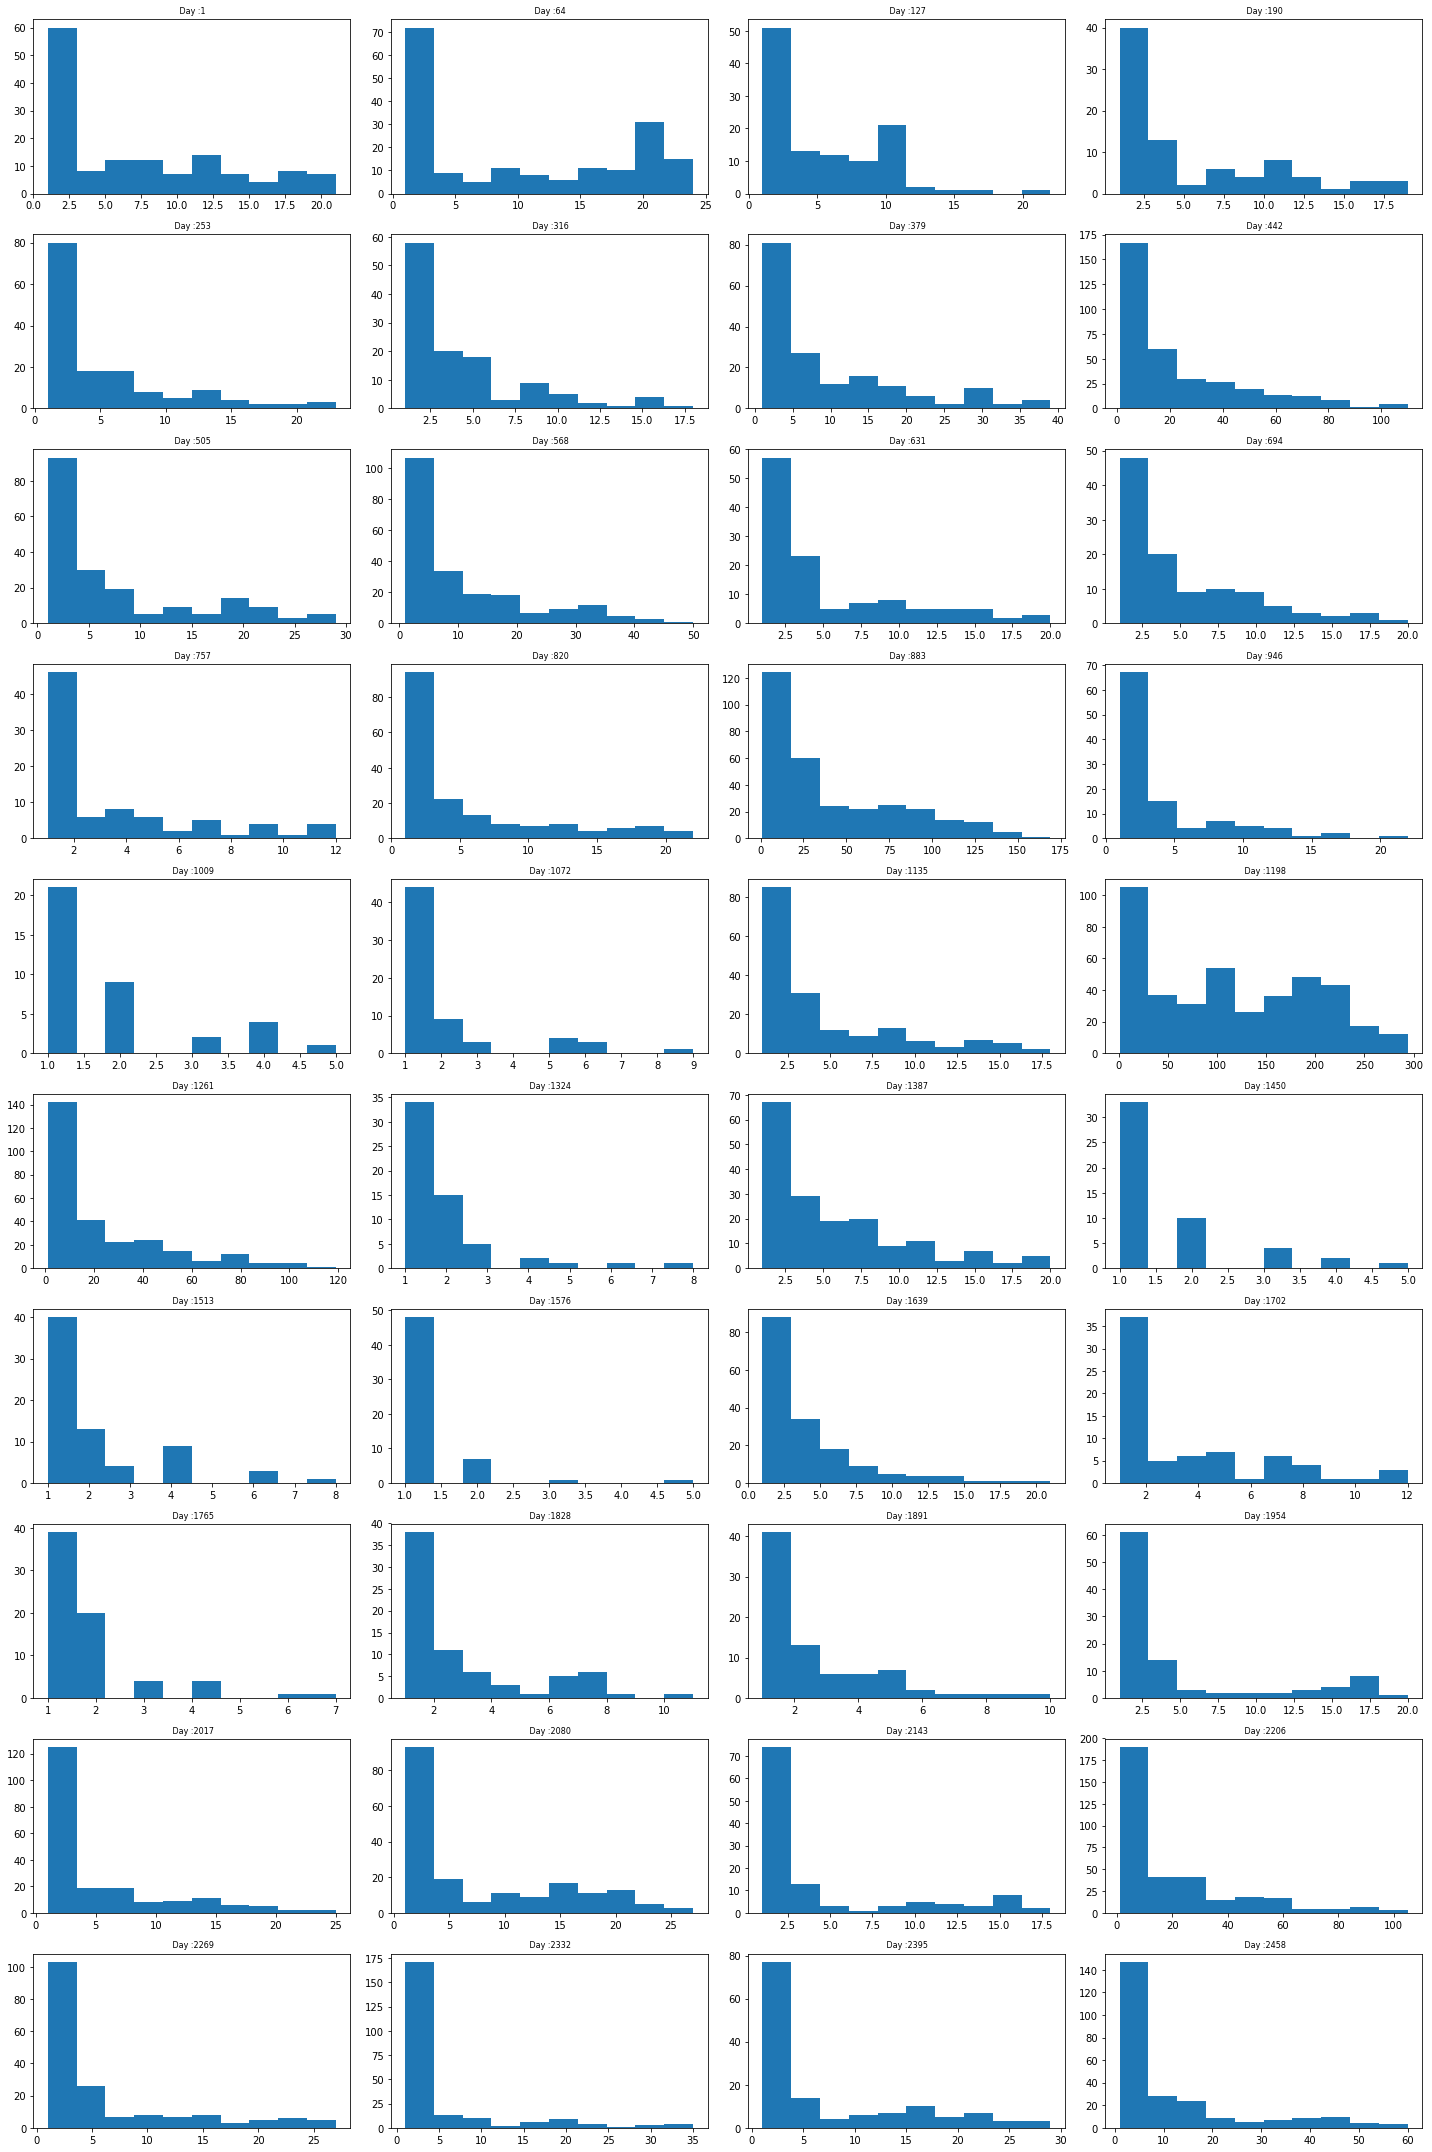

In [24]:
## Explore graph properties
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=10,ncols=4,figsize=(20, 30))
y = 1
for row in ax:
    for col in row:
        deg_dist = [v for k,v in nx.degree(G_dict[y]).items()]
        deg_dist.sort(reverse=True)
        pdf, bins, patch = col.hist(deg_dist, bins=10)
        col.set_title ( " Day :" + str(y),fontsize=8 )
        y = y + W
plt.tight_layout()
plt.show()

### Minimum Spanning Tree Method

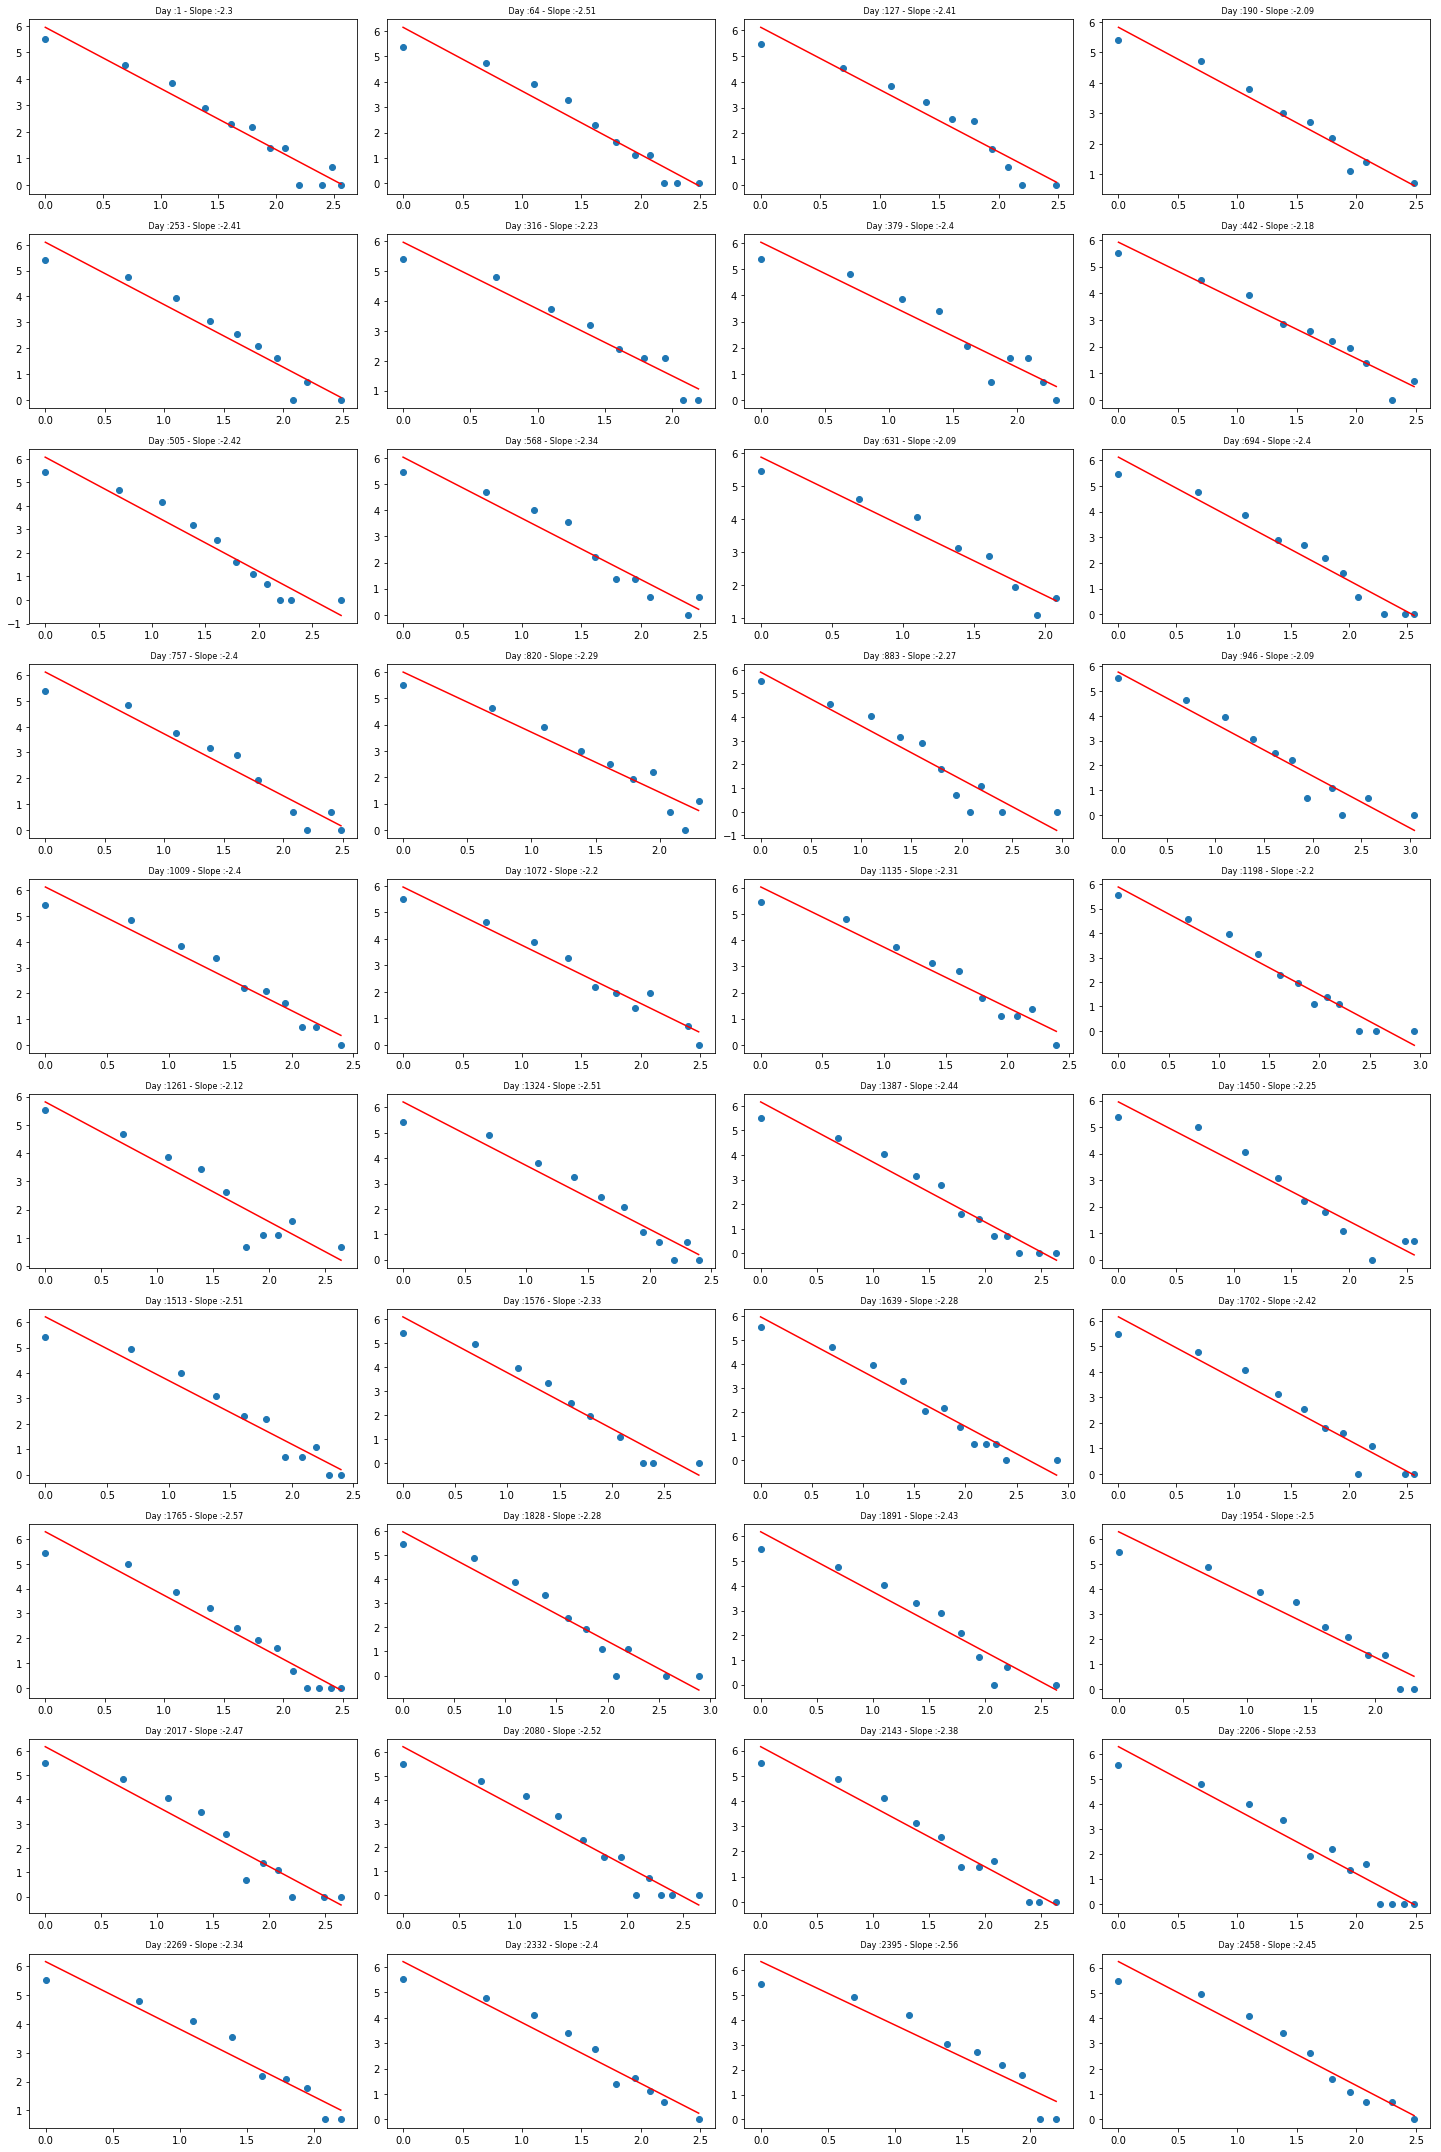

In [27]:
## Explore graph properties
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import linregress
fig, ax = plt.subplots(nrows=10,ncols=4,figsize=(20, 30))
Y = 1
for row in ax:
    for col in row:
        degs = {}
        for n in GMST_dict[Y].nodes() :
            deg = GMST_dict[Y].degree(n)
            if deg not in degs.keys() :
                degs[deg] = 0
            degs[deg] += 1
        items = sorted(degs.items())
        x= [k for (k , v ) in items ]
        y= [ v for (k ,v ) in items ]
        xlog= np.array([np.log(k) for (k , v ) in items ])
        ylog= np.array([np.log(v) for (k ,v ) in items ])
        col.scatter(xlog, ylog)
        slope,intercept,rvalue,pvalue,stderr=linregress(xlog,ylog)
        col.plot(xlog, (slope * xlog + intercept), color='red')
        #ax.set_xscale( 'log' )
        #ax.set_yscale( 'log' )
        col.set_title ( " Day :" + str(Y) + " - Slope :" + str(round(slope,2) ),fontsize=8)
        Y = Y + W
plt.tight_layout()
plt.show()

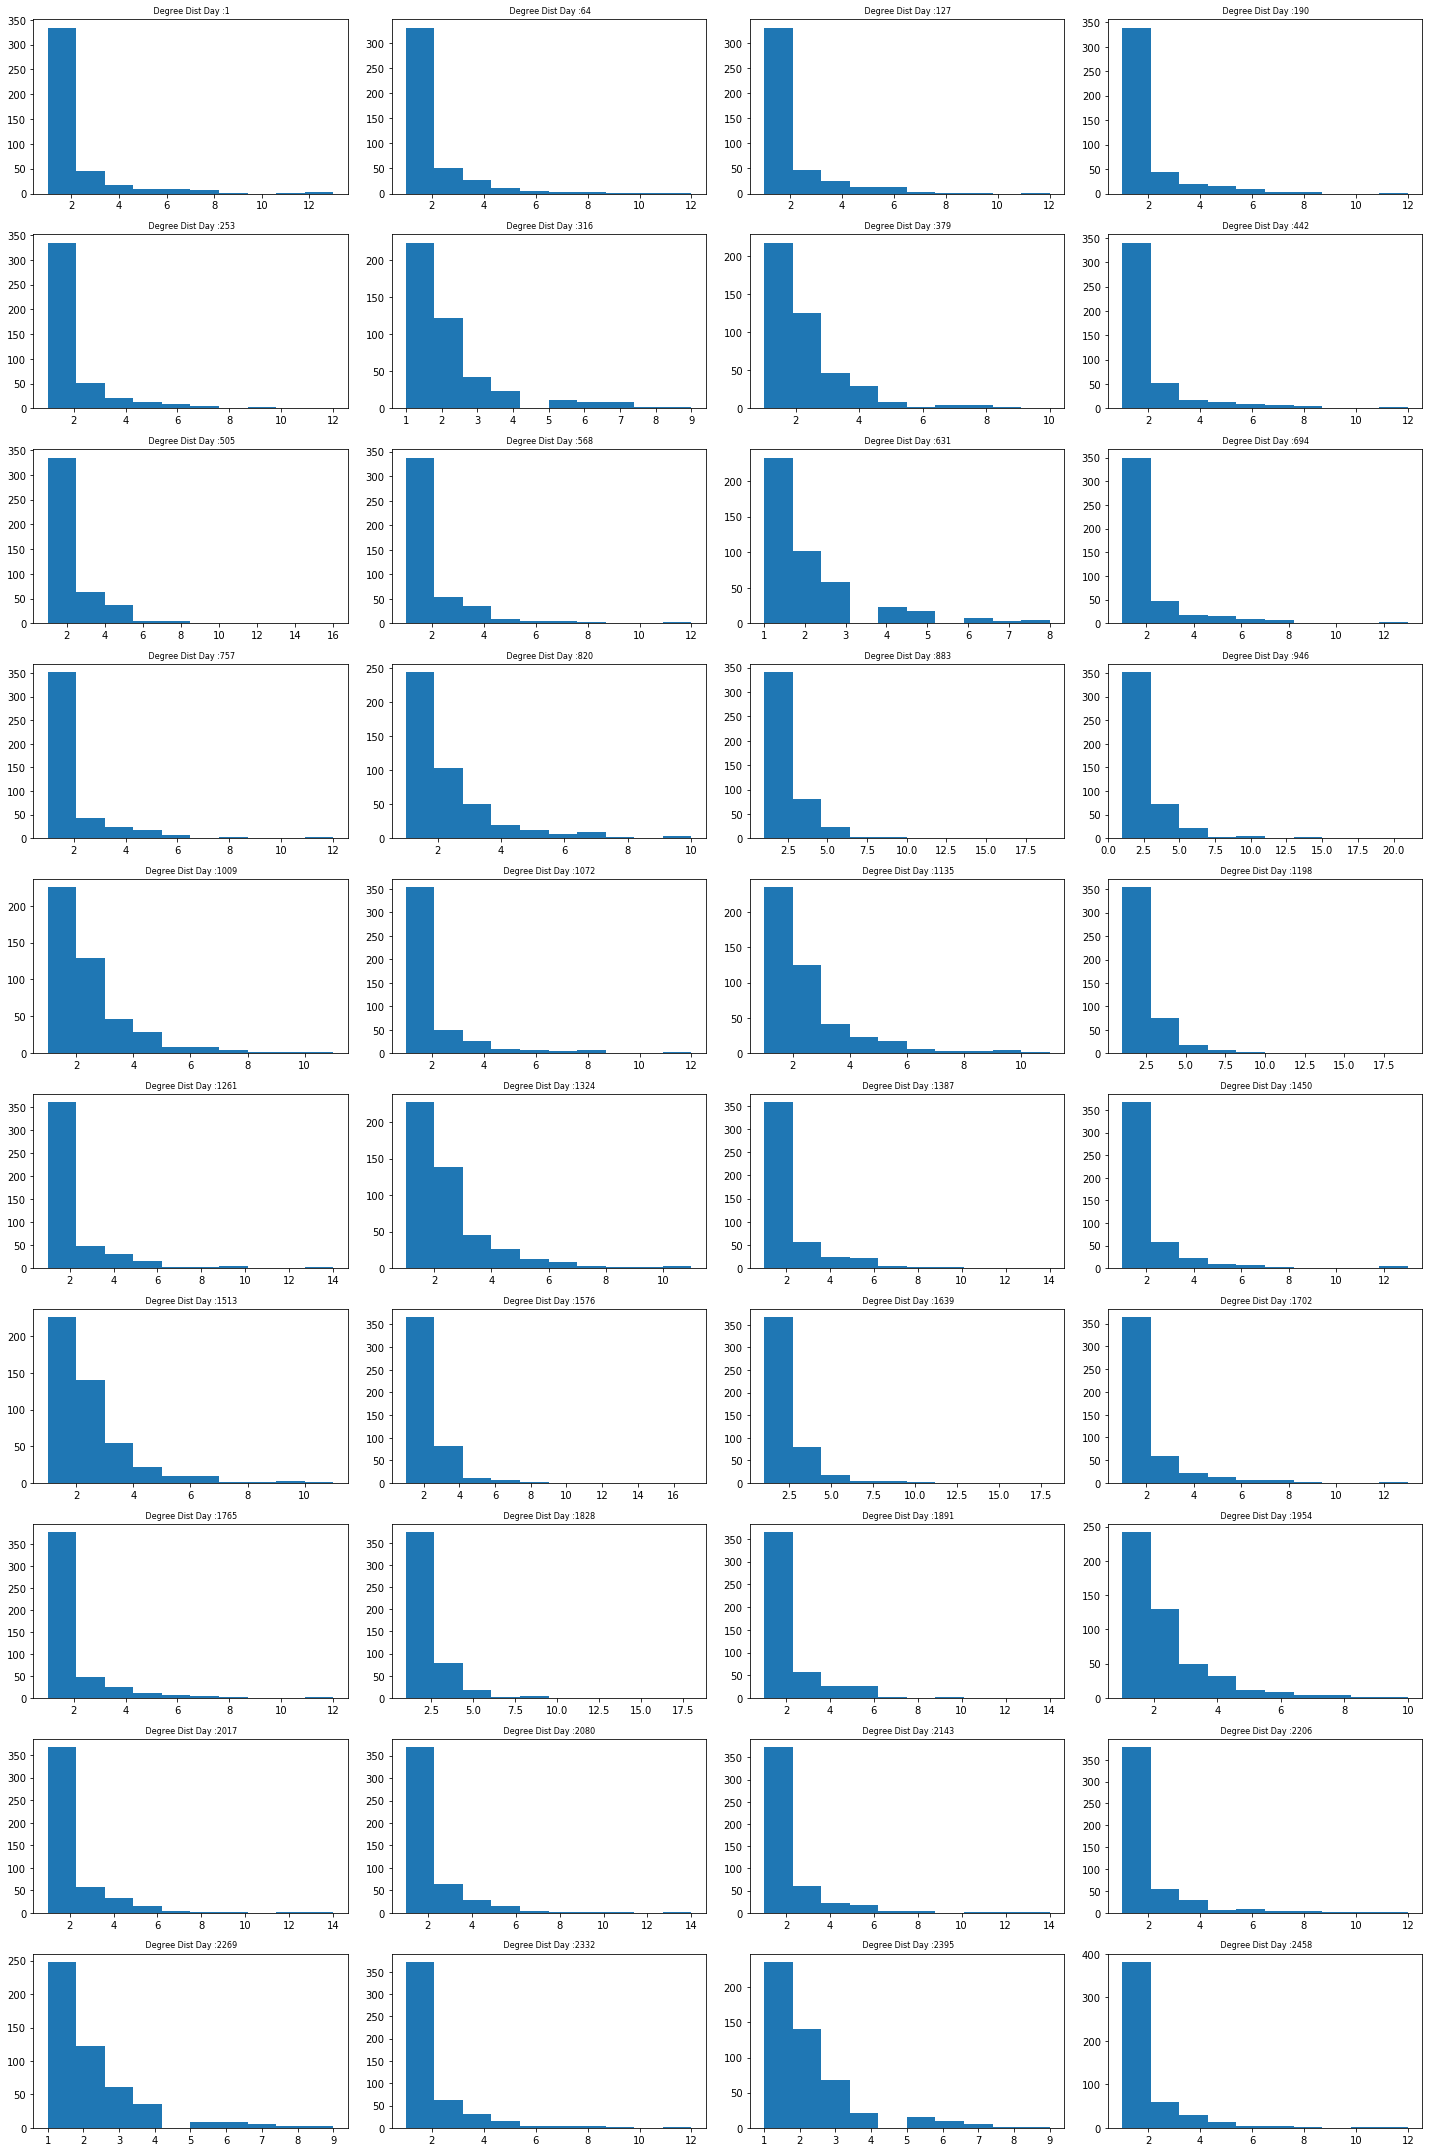

In [28]:
## Explore graph properties
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(nrows=10,ncols=4,figsize=(20, 30))
y = 1
for row in ax:
    for col in row:
        deg_dist = [v for k,v in nx.degree(GMST_dict[y]).items()]
        deg_dist.sort(reverse=True)
        pdf, bins, patch = col.hist(deg_dist, bins=10)
        col.set_title ( " Degree Dist Day :" + str(y),fontsize=8 )
        y = y + W
plt.tight_layout()
plt.show()

### 5.2 Average degree of the network over time

We looked at the change in the average degree degree over time .For the networks from the Winner Take All method we can see that this varies widely overtime indicating the dynamic nature of the stock market.The peaks in the graph correspond well to major events in the market such as the 2008 - 2009 subprime crisis.However for the networks based on the MST method the Average degree is constant this is one of the key drawbacks of the MST method were major fluctuations in the market are not well represented in the network.We can also see in the plot that during normal time periods the Average Degree between the networks from both the methods is the same.

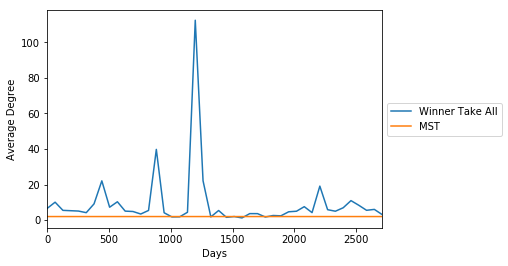

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
avgdf=attrib_df.groupby(by=['start'])['Degree'].mean()
avgdf.plot()
avgdf=attribMST_df.groupby(by=['start'])['Degree'].mean()
avgdf.plot()
plt.xlabel('Days')
plt.ylabel('Average Degree')
plt.legend(['Winner Take All','MST'], loc='center left', bbox_to_anchor=(1, 0.5),ncol=1)
plt.show()

## 5.3 High degree stocks in the network
We looked at the high degree stocks in the network at different windows to get out the important stocks which have high influence or which are a good indicator of how the stock market as whole is moving.The results are below.As we can see the stocks from financials sector have the highest degree in a number of windows .Is there a pattern here?

### Winner Take All Method

In [37]:
attrib_df.sort_values(['start','Degree'],ascending=False).groupby(['start']).head(3)[['start','ticker','Name','Degree','Sector']]

start ticker                               Name  Degree  \
995    2710    DVN                 Devon Energy Corp.    14.0   
2774   2710    RIG                         Transocean    14.0   
2026   2710    MRO                 Marathon Oil Corp.    12.0   
2576   2647    PRU               Prudential Financial    24.0   
3202   2647    UNM                         Unum Group    24.0   
2516   2647    PNC             PNC Financial Services    23.0   
3572   2584    AEE                        Ameren Corp    18.0   
4092   2584    LNT                Alliant Energy Corp    18.0   
4257   2584    PNW              Pinnacle West Capital    18.0   
2058   2521     MS                     Morgan Stanley    39.0   
4819   2521    DFS        Discover Financial Services    38.0   
2271   2521      O          Realty Income Corporation    36.0   
172    2458    AMP               Ameriprise Financial    60.0   
4514   2458    ETN                  Eaton Corporation    56.0   
5307   2458    MCO                       Moody's Corp    56.0   
2572   2395    PRU               Prudential Financial    29.0   
546    2395      C                     Citigroup Inc.    28.0   
2056   2395     MS                     Morgan Stanley    28.0   
2055   2332     MS                     Morgan Stanley    35.0   
2511   2332    PNC             PNC Financial Services    33.0   
475    2332     BK  The Bank of New York Mellon Corp.    32.0   
413    2269    BBT                   BB&T Corporation    27.0   
2510   2269    PNC             PNC Financial Services    26.0   
2570   2269    PRU               Prudential Financial    26.0   
5261   2206    HON               Honeywell Int'l Inc.   105.0   
3391   2206    WFC                        Wells Fargo    96.0   
6474   2206  BRK.B                 Berkshire Hathaway    96.0   
509    2143    BXP                  Boston Properties    18.0   
2716   2143    REG        Regency Centers Corporation    17.0   
1263   2143    FRT    Federal Realty Investment Trust    16.0   
167    2080    AMP               Ameriprise Financial    27.0   
3021   2080    STI                     SunTrust Banks    25.0   
3390   2080    WFC                        Wells Fargo    25.0   
166    2017    AMP               Ameriprise Financial    25.0   
1989   2017    MET                       MetLife Inc.    25.0   
1503   2017    HES                   Hess Corporation    21.0   
845    1954      D                 Dominion Resources    20.0   
3353   1954    WEC               Wec Energy Group Inc    18.0   
3468   1954    XEL                    Xcel Energy Inc    18.0   
649    1891    CMS                         CMS Energy    10.0   
3467   1891    XEL                    Xcel Energy Inc     9.0   
3078   1891    TMK                    Torchmark Corp.     8.0   
163    1828    AMP               Ameriprise Financial    11.0   
2563   1828    PRU               Prudential Financial     8.0   
1862   1828    LNC                   Lincoln National     7.0   
3388   1765    WFC                        Wells Fargo     7.0   
5812   1765      L                        Loews Corp.     6.0   
162    1765    AMP               Ameriprise Financial     4.0   
2342   1702    PEG       Public Serv. Enterprise Inc.    12.0   
3153   1702    UDR                            UDR Inc    12.0   
3349   1702    WEC               Wec Energy Group Inc    12.0   
2371   1639    PFG          Principal Financial Group    21.0   
3348   1639    WEC               Wec Energy Group Inc    17.0   
4077   1639    LNT                Alliant Energy Corp    16.0   
1858   1576    LNC                   Lincoln National     5.0   
2560   1576    PRU               Prudential Financial     3.0   
130    1576    AMG      Affiliated Managers Group Inc     2.0   
3462   1513    XEL                    Xcel Energy Inc     8.0   
39     1513    AEP            American Electric Power     6.0   
943    1513    DTE                     DTE Energy Co.     6.0   
2291   1450    OXY               Occident

### Minimum Spanning Tree Method

In [49]:
attribMST_df.sort_values(['start','Degree'],ascending=False).groupby(['start']).head(3)[['start','ticker','Name','Degree','Sector']]

start ticker                                    Name  Degree  \
8578    2710    HON                    Honeywell Int'l Inc.     9.0   
8314    2710    HCP                                HCP Inc.     7.0   
14900   2710    RIG                              Transocean     7.0   
3996    2647    CMS                              CMS Energy    11.0   
1757    2647    APH                           Amphenol Corp     8.0   
14987   2647    ROK                Rockwell Automation Inc.     8.0   
5395    2584    DOV                             Dover Corp.     9.0   
11918   2584    MRO                      Marathon Oil Corp.     9.0   
13622   2584    PEP                            PepsiCo Inc.     9.0   
2767    2521  BRK.B                      Berkshire Hathaway     8.0   
3774    2521     CL                       Colgate-Palmolive     8.0   
18505   2521    XEL                         Xcel Energy Inc     8.0   
6361    2458    ETN                       Eaton Corporation    12.0   
3949    2458    CMI                            Cummins Inc.    10.0   
11388   2458    MCO                            Moody's Corp    10.0   
1313    2395    AMG           Affiliated Managers Group Inc     9.0   
9585    2395    ITW                     Illinois Tool Works     8.0   
3992    2395    CMS                              CMS Energy     7.0   
37      2332      A                Agilent Technologies Inc    12.0   
11958   2332     MS                          Morgan Stanley     9.0   
14146   2332    PPG                          PPG Industries     9.0   
4342    2269    COP                          ConocoPhillips     9.0   
10111   2269    KMB                          Kimberly-Clark     9.0   
8571    2269    HON                    Honeywell Int'l Inc.     8.0   
8570    2206    HON                    Honeywell Int'l Inc.    12.0   
11384   2206    MCO                            Moody's Corp    11.0   
9846    2206    JPM                    JPMorgan Chase & Co.    10.0   
430     2143    ADP               Automatic Data Processing    14.0   
17399   2143    UTX                     United Technologies    12.0   
11647   2143    MMC                        Marsh & McLennan    11.0   
1396    2080    AMP                    Ameriprise Financial    14.0   
9580    2080    ITW                     Illinois Tool Works    11.0   
11690   2080    MMM                              3M Company    10.0   
1395    2017    AMP                    Ameriprise Financial    14.0   
6926    2017    FIS  Fidelity National Information Services    12.0   
9579    2017    ITW                     Illinois Tool Works     9.0   
11688   1954    MMM                              3M Company    10.0   
1394    1954    AMP                    Ameriprise Financial     9.0   
2626    1954    BLK                               BlackRock     8.0   
8565    1891    HON                    Honeywell Int'l Inc.    14.0   
13831   1891     PH                         Parker-Hannifin     9.0   
16471   1891    TMK                         Torchmark Corp.     9.0   
16470   1828    TMK                         Torchmark Corp.    18.0   
1260    1828    AME                              AMETEK Inc    13.0   
1392    1828    AMP                    Ameriprise Financial     9.0   
13697   1765    PFG               Principal Financial Group    12.0   
18009   1765    WFC                             Wells Fargo    11.0   
1391    1765    AMP                    Ameriprise Financial    10.0   
1390    1702    AMP                    Ameriprise Financial    13.0   
8562    1702    HON                    Honeywell Int'l Inc.    12.0   
13564   1702    PEG            Public Serv. Enterprise Inc.     9.0   
13695   1639    PFG               Principal Financial Group    18.0   
17963   1639    WEC                    Wec Energy Group Inc    11.0   
1653    1639    APC                 Anadarko Petroleum Corp    10.0   
1388    1576    AMP                    Ameriprise Financial    17.0   
16554   1576   TROW            

We plotted the count of the sector of the high degree stock in the windows and we can see that Finance  stocks definetly are the center of the market network.This kind of makes sense since Finance stocks are structurally dependent on what happens in the other sectors and we can expect them to be the important stocks which are correlated to many of the other stocks in the market. 

In [60]:
df1=attrib_df.sort_values(['start','Degree'],ascending=False).groupby(['start']).head(3).groupby(['Sector']).count()['ticker']
df2=attribMST_df.sort_values(['start','Degree'],ascending=False).groupby(['start']).head(3).groupby(['Sector']).count()['ticker']
df3=pd.concat([df1, df2], axis=1).fillna(0)
df3.columns = ['t1','t2']

[]

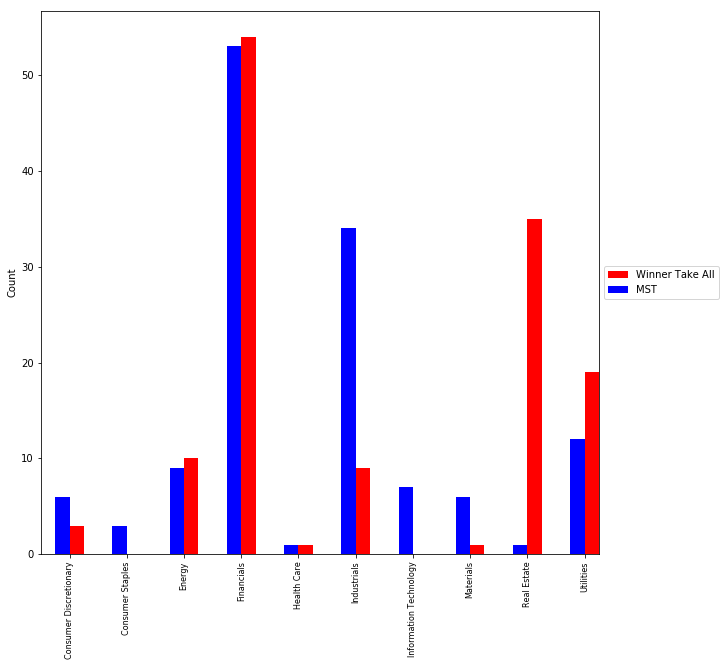

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(10,10))
df3['t1'].plot(kind='bar',color='red',  position=0, width=0.25)
df3['t2'].plot(kind='bar',color='blue',  position=1, width=0.25)
plt.xticks(rotation=90,fontsize=8)
plt.ylabel('Count')
plt.legend(['Winner Take All','MST'], loc='center left', bbox_to_anchor=(1, 0.5),ncol=1)
plt.plot()

## 5.4 Stocks With High Betweenness Centrality
We looked at the stocks with high betweeness Centrality in the network at different windows to get out the important stocks which because of the position in the network will be good predictors in the movement of prices of the stocks.The results are below.As we can see financials stocks still lead in most periods .

### Winner Take All Method

In [34]:
attrib_df.sort_values(['start','Betweeness'],ascending=False).groupby(['start']).head(3)[['start','ticker','Name','Betweeness','Sector']]

start ticker                              Name  Betweeness  \
6727   2710   FOXA  Twenty-First Century Fox Class A    0.007932   
5244   2710   HOLX                           Hologic    0.006344   
6673   2710   MDLZ            Mondelez International    0.004696   
3202   2647    UNM                        Unum Group    0.011359   
2576   2647    PRU              Prudential Financial    0.007036   
1653   2647    JPM              JPMorgan Chase & Co.    0.005982   
1874   2584    LNC                  Lincoln National    0.006935   
1363   2584     GS               Goldman Sachs Group    0.006339   
3547   2584   ZION                     Zions Bancorp    0.005442   
6454   2521    MMC                  Marsh & McLennan    0.260341   
5493   2521    BDX                  Becton Dickinson    0.246517   
5376   2521      A          Agilent Technologies Inc    0.240836   
5221   2458    DOV                       Dover Corp.    0.098698   
4514   2458    ETN                 Eaton Corporation    0.052089   
2182   2458    NOV       National Oilwell Varco Inc.    0.051739   
2572   2395    PRU              Prudential Financial    0.016133   
171    2395    AMP              Ameriprise Financial    0.008358   
2056   2395     MS                    Morgan Stanley    0.005031   
3792   2332    DHR                     Danaher Corp.    0.114964   
6731   2332    XYL                        Xylem Inc.    0.111858   
2414   2332     PH                   Parker-Hannifin    0.101198   
544    2269      C                    Citigroup Inc.    0.015129   
689    2269    COF             Capital One Financial    0.012840   
4141   2269   MSFT                   Microsoft Corp.    0.010529   
5261   2206    HON              Honeywell Int'l Inc.    0.178959   
5790   2206    KMB                    Kimberly-Clark    0.099971   
3504   2206    XOM                 Exxon Mobil Corp.    0.096947   
4569   2143    NOC            Northrop Grumman Corp.    0.003051   
4615   2143    UTX               United Technologies    0.003051   
4085   2143    LNT               Alliant Energy Corp    0.002730   
1614   2080    ITW               Illinois Tool Works    0.024743   
442    2080    BEN                Franklin Resources    0.021179   
2411   2080     PH                   Parker-Hannifin    0.017146   
1047   2017    EMR          Emerson Electric Company    0.043283   
441    2017    BEN                Franklin Resources    0.043158   
6016   2017    ROP                  Roper Industries    0.036402   
845    1954      D                Dominion Resources    0.010613   
1146   1954    ESS        Essex Property Trust, Inc.    0.008675   
2343   1954    PEG      Public Serv. Enterprise Inc.    0.006047   
5258   1891    HON              Honeywell Int'l Inc.    0.068598   
3078   1891    TMK                   Torchmark Corp.    0.047453   
2504   1891    PNC            PNC Financial Services    0.039960   
3077   1828    TMK                   Torchmark Corp.    0.077264   
6446   1828    MMC                  Marsh & McLennan    0.076123   
163    1828    AMP              Ameriprise Financial    0.072502   
3388   1765    WFC                       Wells Fargo    0.031168   
5812   1765      L                       Loews Corp.    0.024583   
3755   1765   CINF              Cincinnati Financial    0.018437   
2342   1702    PEG      Public Serv. Enterprise Inc.    0.013637   
104    1702    AIV       Apartment Investment & Mgmt    0.013070   
3349   1702    WEC              Wec Energy Group Inc    0.012457   
2371   1639    PFG         Principal Financial Group    0.111754   
2790   1639    ROK          Rockwell Automation Inc.    0.061661   
2013   1639    MRO                Marathon Oil Corp.    0.043269   
1858   1576    LNC                  Lincoln National    0.010065   
159    1576    AMP              Ameriprise Financial    0.006494   
130    1576    AMG     Affiliated Managers Group Inc    0.003896   
1857   1513    LNC                  Lincoln National    0.0526

### Minimum Spanning Tree Method

In [33]:
attribMST_df.sort_values(['start','Betweeness'],ascending=False).groupby(['start']).head(3)[['start','ticker','Name','Betweeness','Sector']]

start ticker                                Name  Betweeness  \
2418    2710    BEN                  Franklin Resources    0.649713   
18946   2710    IVZ                        Invesco Ltd.    0.581805   
8578    2710    HON                Honeywell Int'l Inc.    0.477113   
17187   2647    UNM                          Unum Group    0.570723   
2109    2647    BAC                Bank of America Corp    0.565530   
9589    2647    ITW                 Illinois Tool Works    0.548996   
10686   2584    LNC                    Lincoln National    0.623492   
11038   2584     MA                     Mastercard Inc.    0.599686   
13710   2584    PFG           Principal Financial Group    0.509717   
2767    2521  BRK.B                  Berkshire Hathaway    0.618615   
11653   2521    MMC                    Marsh & McLennan    0.543698   
2371    2521    BDX                    Becton Dickinson    0.524445   
1402    2458    AMP                Ameriprise Financial    0.654670   
11388   2458    MCO                        Moody's Corp    0.632002   
6361    2458    ETN                   Eaton Corporation    0.462152   
9453    2395     IR                  Ingersoll-Rand PLC    0.625261   
18941   2395    IVZ                        Invesco Ltd.    0.606101   
1313    2395    AMG       Affiliated Managers Group Inc    0.553152   
2104    2332    BAC                Bank of America Corp    0.720245   
11958   2332     MS                      Morgan Stanley    0.605990   
2940    2332      C                      Citigroup Inc.    0.493196   
18017   2269    WFC                         Wells Fargo    0.675696   
3726    2269   CINF                Cincinnati Financial    0.547420   
2763    2269  BRK.B                  Berkshire Hathaway    0.489289   
9846    2206    JPM                JPMorgan Chase & Co.    0.680760   
14232   2206    PRU                Prudential Financial    0.601696   
15816   2206    STI                      SunTrust Banks    0.509497   
430     2143    ADP           Automatic Data Processing    0.642566   
11647   2143    MMC                    Marsh & McLennan    0.627954   
17399   2143    UTX                 United Technologies    0.569319   
1396    2080    AMP                Ameriprise Financial    0.721395   
9580    2080    ITW                 Illinois Tool Works    0.666124   
11558   2080    MKC                     McCormick & Co.    0.279403   
1395    2017    AMP                Ameriprise Financial    0.750213   
15021   2017    ROP                    Roper Industries    0.543654   
15857   2017    STT                  State Street Corp.    0.501954   
2626    1954    BLK                           BlackRock    0.657465   
11468   1954    MET                        MetLife Inc.    0.614263   
14228   1954    PRU                Prudential Financial    0.511184   
8565    1891    HON                Honeywell Int'l Inc.    0.641060   
17395   1891    UTX                 United Technologies    0.638150   
9577    1891    ITW                 Illinois Tool Works    0.495383   
16470   1828    TMK                     Torchmark Corp.    0.720504   
11642   1828    MMC                    Marsh & McLennan    0.528795   
10674   1828    LNC                    Lincoln National    0.479425   
1391    1765    AMP                Ameriprise Financial    0.751050   
19406   1765      L                         Loews Corp.    0.505638   
13697   1765    PFG           Principal Financial Group    0.450503   
1390    1702    AMP                Ameriprise Financial    0.836793   
14532   1702      R                        Ryder System    0.409247   
19014   1702    DFS         Discover Financial Services    0.320586   
13695   1639    PFG           Principal Financial Group    0.847559   
2577    1639     BK   The Bank of New York Mellon Corp.    0.352938   
15543   1639    SNA                        Snap-On Inc.    0.340600   
1388    1576    AMP                Ameriprise Financial    0.802485   
10670   1576    LNC            

We plotted the count of the sector of the high betweenness stocks in the windows and we can see that Finance stocks still lead however industrials come in number two.

In [61]:
df1=attrib_df.sort_values(['start','Betweeness'],ascending=False).groupby(['start']).head(3).groupby(['Sector']).count()['ticker']
df2=attribMST_df.sort_values(['start','Betweeness'],ascending=False).groupby(['start']).head(3).groupby(['Sector']).count()['ticker']
df3=pd.concat([df1, df2], axis=1).fillna(0)
df3.columns = ['t1','t2']

[]

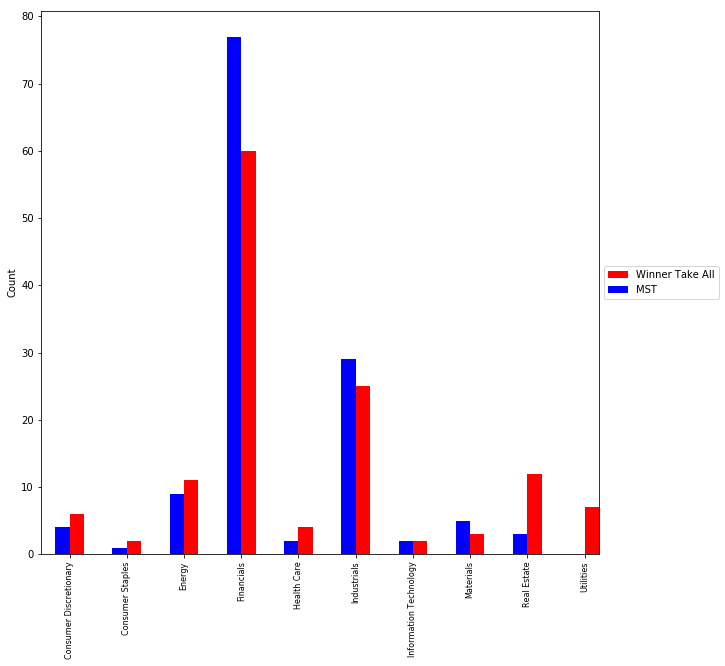

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(10,10))
df3['t1'].plot(kind='bar',color='red',  position=0, width=0.25)
df3['t2'].plot(kind='bar',color='blue',  position=1, width=0.25)
plt.xticks(rotation=90,fontsize=8)
plt.ylabel('Count')
plt.legend(['Winner Take All','MST'], loc='center left', bbox_to_anchor=(1, 0.5),ncol=1)
plt.plot()

## 5.5. Communities detected over time

We looked at the number of communities detected over different periods.The variation in the number of communities denotes the dynamic nature of the market where a number of new communities of stocks are formed in each window and each of which can die or continue into subsequent periods

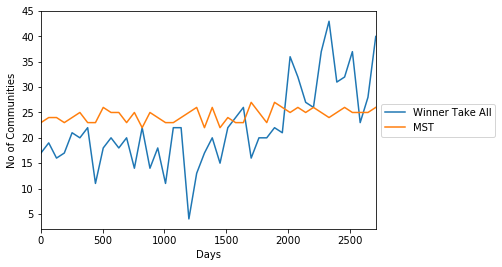

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline
cdf=attrib_df.groupby(by=['start'])['Community'].nunique()
cdf.plot()
cdf=attribMST_df.groupby(by=['start'])['Community'].nunique()
cdf.plot()
plt.legend(['Winner Take All','MST'], loc='center left', bbox_to_anchor=(1, 0.5),ncol=1)
plt.xlabel('Days')
plt.ylabel('No of Communities')
plt.show()

## 5.6 Jaccard Similarity of Communities Detected with Sector Code
One the key points we wanted to look as part of the project was too see if the network created based on the stock prizes has any relationship to the SIC(Standard Industry classification Code) of these stocks .That is do the Financial,Industrial and IT  stocks trade in a group ?.So to study the similarity of the communities detected with the SIC code of these stocks in the SP500 we computed the Jaccard similarity coefficient of these communities in each of the time windows with the stock list grouped by industry code.

We converted the stock list in  the communities detected and the stock list as per the SIC code into a binary matrix.The presence of the stock in the community/group is denoted by 1 and the absence by 0.

Given two objects, A and B, each with n binary attributes, the Jaccard coefficient is a useful measure of the overlap that A and B share with their attributes. Each attribute of A and B can either be 0 or 1. The total number of each combination of attributes for both A and B are specified as follows:

    - M_11 represents the total number of attributes where A and B both have a value of 1.
    - M_01 represents the total number of attributes where the attribute of A is 0 and the attribute of B is 1.
    - M_10 represents the total number of attributes where the attribute of A is 1 and the attribute of B is 0.
    - M_00 represents the total number of attributes where A and B both have a value of 0.

Each attribute must fall into one of these four categories, meaning that
M_11 + M_01 + M_10 + M_00 = n.

The Jaccard similarity coefficient, J, is given as

$$J = {M_{11} \over M_{01} + M_{10} + M_{11}}$$

So if a particular community has a Jaccard coefficient of more than 0.25 with the the group of stocks classified by the SIC code we classified the community as that particular SIC code .The plot is below and provides a interesting result.

So as we can visuvalize some sectors are well correlated or connected and the communities detected clearly indicate these stocks trade in groups over different periods

    Finance
    Real Estate
    Utilities
    Energy
    Telecommunication
    Industrials
    
However , the interesting result is that there are certain sectors which don't trade as groups .We don't see any communities being detected in these sectors.This seems to indicate that these sectors has various other stock specific factors at play in the market and they don't generally trade as a group

    Information Technology
    Materials
    Consumer Staples
    Consumer Discretionary
    Health Care

In [64]:
cmatrix = attrib_df.groupby(by=['start','Community','ticker'])['ticker'].count().unstack()
cmatrix.fillna(0,inplace=True)
smatrix = attrib_df.groupby(by=['Sector','ticker'])['ticker'].count().unstack()
smatrix.fillna(0,inplace=True)
smatrix[smatrix != 0] = 1
csmatrix=pd.concat([smatrix,cmatrix])
jval = {}
for idxs,rows  in smatrix.iterrows():
    xlist = []
    ylist = []
    for idxc,rowc in cmatrix.iterrows():
        x = [int(i) for i in rows]
        y = [int(i) for i in rowc]
        jc = (np.double(np.bitwise_and(x, y).sum()) / np.double(np.bitwise_or(x, y).sum()))
        if jc > 0.25:
            xlist.append(idxc[0])
            ylist.append(jc)
    jval[idxs] = [xlist,ylist]

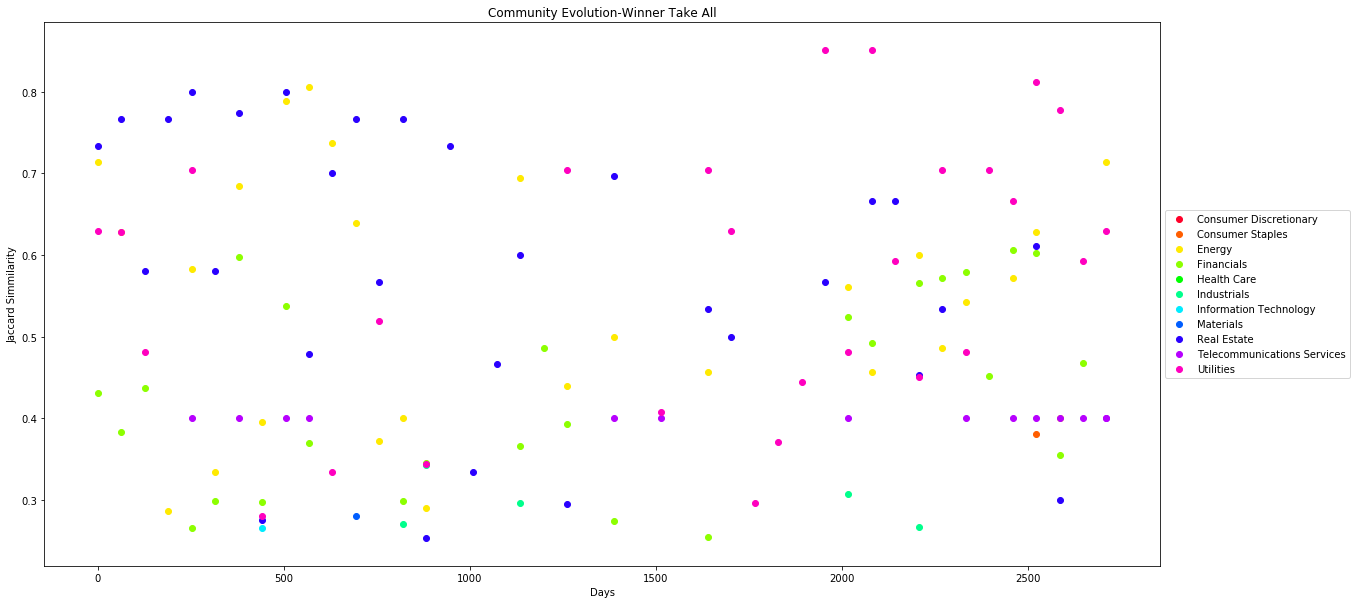

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,10))
cm = plt.get_cmap('gist_rainbow')
NUM_COLORS = 11
colors = [cm(i) for i in np.linspace(0,1,NUM_COLORS)]
color_dict=dict(zip(list(jval.keys()), colors))
for key in jval:
    x = jval[key][0]
    y = jval[key][1]
    plt.scatter(x,y,color=color_dict[key],label=key)
    
#plt.legend(list(jval.keys()), loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Days')
plt.ylabel('Jaccard Simmilarity')
plt.title('Community Evolution-Winner Take All')
plt.show()

In [66]:
cmatrix = attribMST_df.groupby(by=['start','Community','ticker'])['ticker'].count().unstack()
cmatrix.fillna(0,inplace=True)
smatrix = attribMST_df.groupby(by=['Sector','ticker'])['ticker'].count().unstack()
smatrix.fillna(0,inplace=True)
smatrix[smatrix != 0] = 1
csmatrix=pd.concat([smatrix,cmatrix])
jval = {}
for idxs,rows  in smatrix.iterrows():
    xlist = []
    ylist = []
    for idxc,rowc in cmatrix.iterrows():
        x = [int(i) for i in rows]
        y = [int(i) for i in rowc]
        jc = (np.double(np.bitwise_and(x, y).sum()) / np.double(np.bitwise_or(x, y).sum()))
        if jc > 0.25:
            xlist.append(idxc[0])
            ylist.append(jc)
    jval[idxs] = [xlist,ylist]

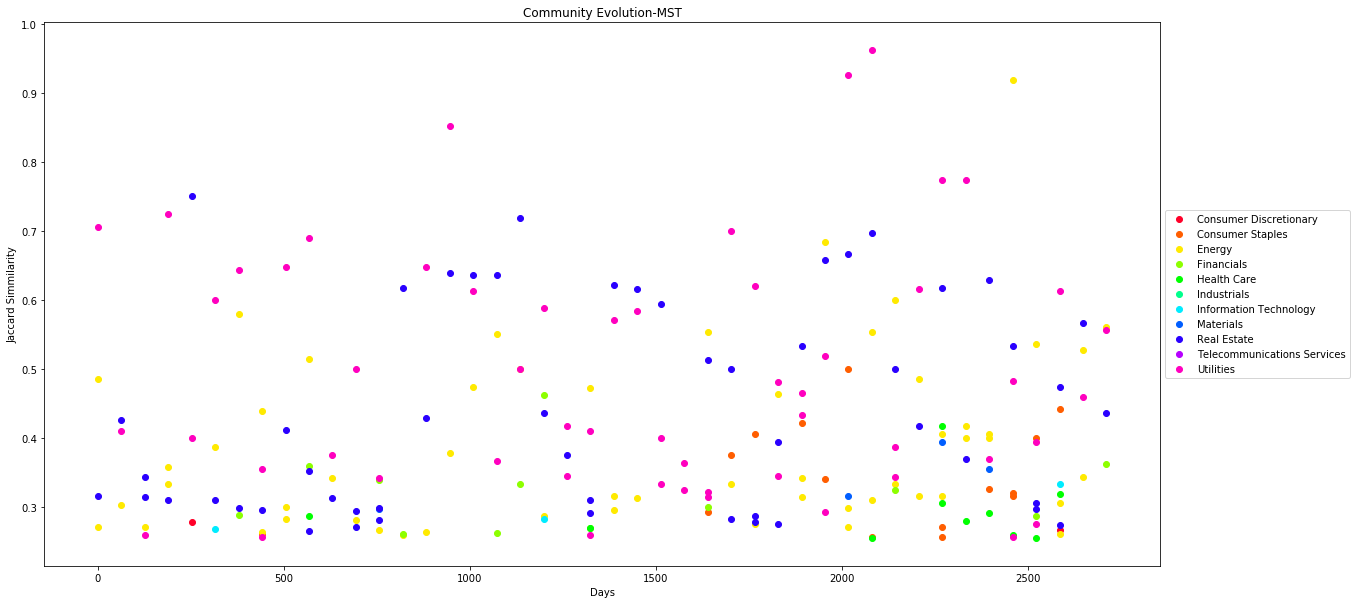

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,10))
cm = plt.get_cmap('gist_rainbow')
NUM_COLORS = 11
colors = [cm(i) for i in np.linspace(0,1,NUM_COLORS)]
color_dict=dict(zip(list(jval.keys()), colors))
for key in jval:
    x = jval[key][0]
    y = jval[key][1]
    plt.scatter(x,y,color=color_dict[key],label=key)
    
#plt.legend(list(jval.keys()), loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Days')
plt.ylabel('Jaccard Simmilarity')
plt.title('Community Evolution-MST')
plt.show()

## 5.7 Visuvalize the network and the evolution

We then merged the graphs from different windows into one graph assigned and exported the output to gexf format to visuvalise the dynamic evolution of the network.Since the networkx gexf export doesn't support dynamic attributes we uses XML parsing to convert the GEXF file to include the dynamic attributes and visuvalised the network and its dynamic evolution in Gephi

The video is available here

https://www.youtube.com/watch?v=KGpEs97YWJ4


In [68]:
# Constructing a graph
import networkx as nx
M=nx.MultiGraph()
for y in G_dict.keys():
    M.add_nodes_from(G_dict[y].nodes(data=True))
    M.add_edges_from(G_dict[y].edges(data=True))
nx.write_gexf(M,'data/price-sp500.gexf')

In [69]:
import xml.etree.ElementTree as ET
tree = ET.parse('data/price-sp500.gexf')
root = tree.getroot()
for element in root.iter("{http://www.gexf.net/1.1draft}node"):
    #print (element.attrib)
    noden = element.attrib['id']
    for child in element:
        for i in range(len(child)):
            child.remove(child[0])
        for y in G_dict.keys():
            T = G_dict[y]
            n = 0
            try:
                for att in T.node[noden]:
                    new = ET.Element("{http://www.gexf.net/1.1draft}attvalue")
                    new.set('for',str(n))
                    new.set('value',str(T.node[noden][att]))
                    new.set('start',str(y))
                    new.set('end',str(y+W-1))
                    child.append(new)
                    #print (T.node[noden][att])
                    n = n + 1
            except:
                continue
for element in root.iter("{http://www.gexf.net/1.1draft}edge"):
    #print (element.attrib)
    noden = element.attrib['id']
    for child in element:
        for i in range(len(child)):
            child[i].set('start',str(element.attrib['start']))
            child[i].set('end',str(element.attrib['end']))
tree.write('data/price-sp500-o.gexf')

In [70]:
# Constructing a graph
import networkx as nx
M=nx.MultiGraph()
for y in GMST_dict.keys():
    M.add_nodes_from(GMST_dict[y].nodes(data=True))
    M.add_edges_from(GMST_dict[y].edges(data=True))
nx.write_gexf(M,'data/price-MST-sp500.gexf')

In [71]:
import xml.etree.ElementTree as ET
tree = ET.parse('data/price-MST-sp500.gexf')
root = tree.getroot()
for element in root.iter("{http://www.gexf.net/1.1draft}node"):
    #print (element.attrib)
    noden = element.attrib['id']
    for child in element:
        for i in range(len(child)):
            child.remove(child[0])
        for y in GMST_dict.keys():
            T = GMST_dict[y]
            n = 0
            try:
                for att in T.node[noden]:
                    new = ET.Element("{http://www.gexf.net/1.1draft}attvalue")
                    new.set('for',str(n))
                    new.set('value',str(T.node[noden][att]))
                    new.set('start',str(y))
                    new.set('end',str(y+W-1))
                    child.append(new)
                    #print (T.node[noden][att])
                    n = n + 1
            except:
                continue
for element in root.iter("{http://www.gexf.net/1.1draft}edge"):
    #print (element.attrib)
    noden = element.attrib['id']
    for child in element:
        for i in range(len(child)):
            child[i].set('start',str(element.attrib['start']))
            child[i].set('end',str(element.attrib['end']))
tree.write('data/price-MST-sp500-o.gexf')

## Conclusion

In conclusion we have been able to find answers to our questions and find some interesting results on the dynamics of the Equities in the S and P 500 index through Network Analysis.

We have  been able to

    1. Build networks for the various phases of the stock market between 2007 and 2017 split based on time periods,  for the stocks in the S and P 500 based  on the Winner Take All and the Minimum Spanning tree Method
    2. Analyse the network and found that the network indeed exhibits scale free properties
    3. Detect communities in these networks and compare these communities with the communities of the stocks based on the SIC code using Jaccard Similarity.
    4. Study the evolution of these communities and noted the essential result that there are some sectors which essentially trade together as a group and some that don't.
    5. Leverage the properties of the network to find the important stocks and the sectors which reflect movement of other stocks in the network
    6. Identify stocks/sectors which based on their Betweeness cetrality are ideally placed to predict the movement of the prices in the market
    7. Visuvalize the dynamic evolution of network by building dynamic graphs  using Gephi
    
The Analysis and the results provide a interesting insight into the stock market and its dynamic nature.The results from this study and further research can be used in areas of Portfolio optimisation, Risk Mitigation etc.Further analysis can also be done by building networks between different asset classes such as currency , commodities  and studying their evolution and behavior over time.

## Appendix

## MST-Network -  Period Starting 1702

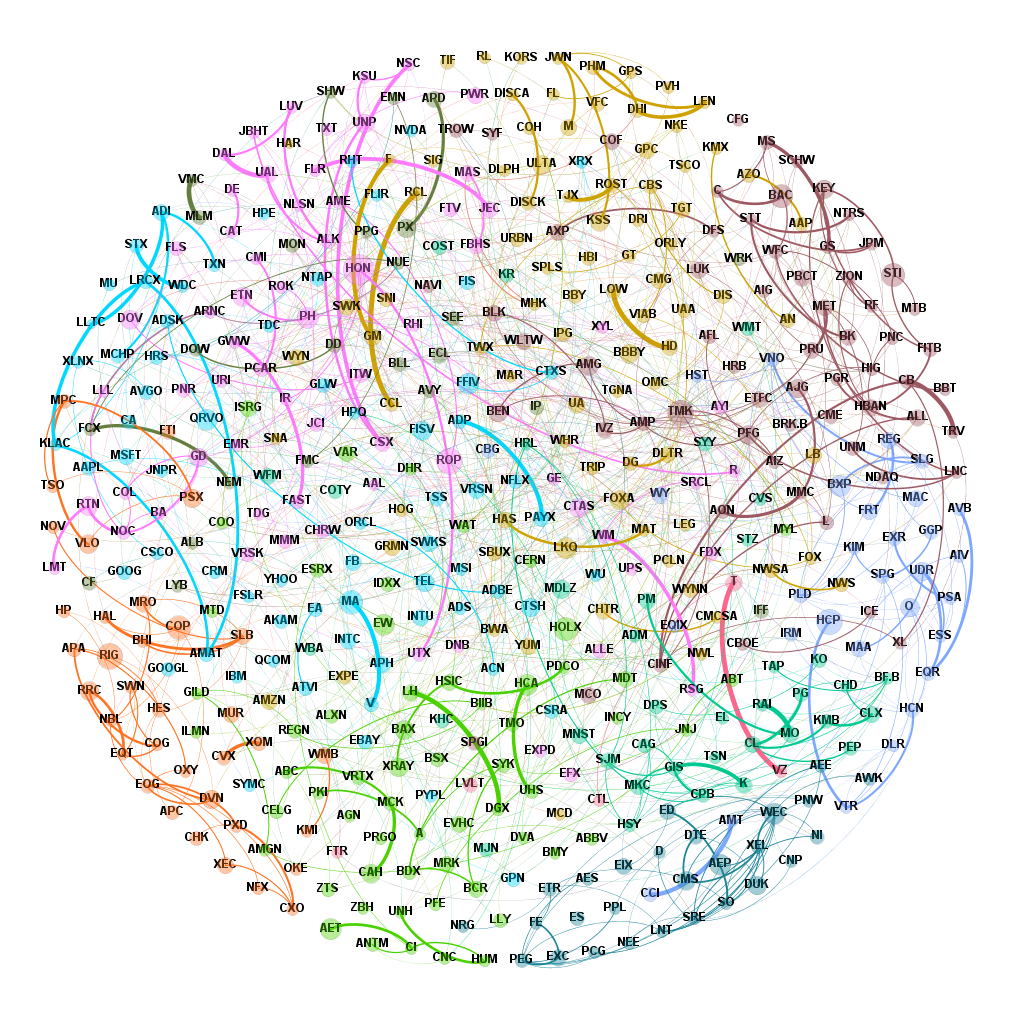

In [72]:
from IPython.display import Image
Image(filename='data/MST-Period-1702.png') 

## Winner Take All -Network -  Period Starting 1702

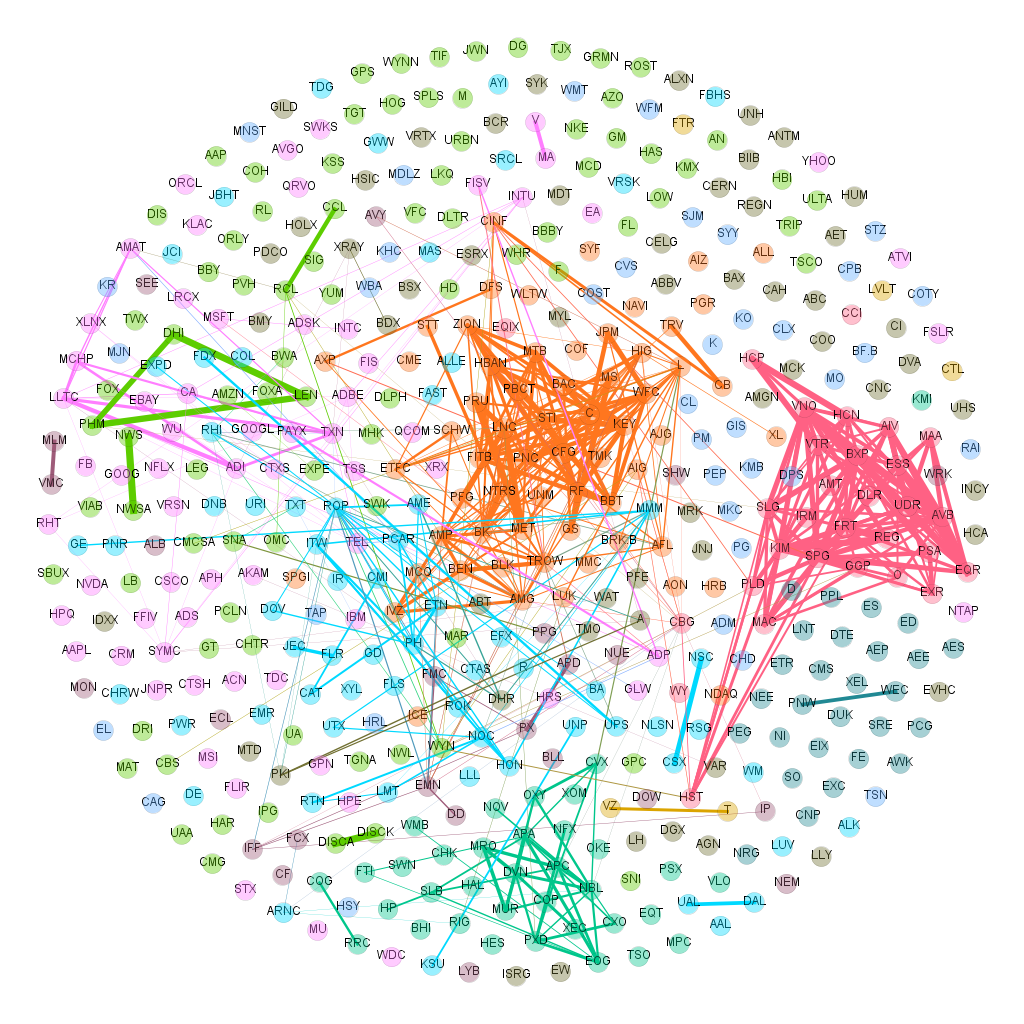

In [74]:
from IPython.display import Image
Image(filename='data/WTA-period-1702.png') 

## Winner Take All -Network -  Period Starting 568

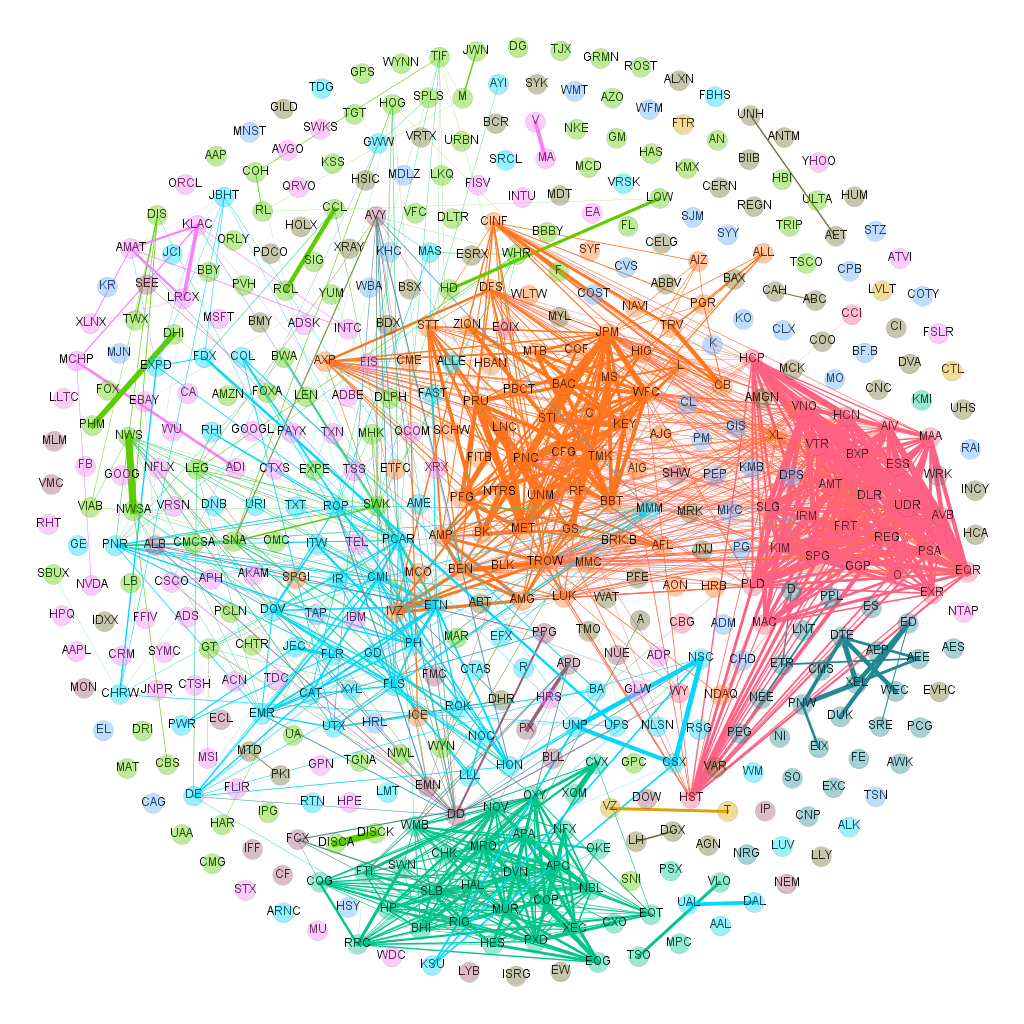

In [75]:
from IPython.display import Image
Image(filename='data/WTA-period-568.png') 